Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = $3\cdot 10^{-2}$
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation of parameters
#o 2?

### Load Data and preprocess

In [3]:
from keras.datasets import cifar10
(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
print("Input shape:",X_train.shape)

Input shape: (50000, 32, 32, 3)


In [4]:
Xstd_train = X_train.astype(DTYPE_OP)/255
Xstd_test = X_test.astype(DTYPE_OP)/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

### Load annotations

In [5]:
#opt = "CIFAR_normal"
#opt = "CIFAR_normal_badMV"
opt = "CIFAR_normal_soft" 
#opt = "CIFAR_manyAnnot_v1" #npy
#opt = "CIFAR_manyAnnot_v2" #npy
#opt = "CIFAR_manyAnnot_v1_badMV" #npy

In [6]:
y_obs = np.loadtxt("../syntetic/CIFAR/annotations_"+opt+".csv" ,delimiter=',',dtype='int')
#y_obs = np.load("../syntetic/CIFAR/annotations_"+opt+".npy" )

groups_annot = np.loadtxt("../syntetic/CIFAR/annotgroups_"+opt+".csv",delimiter=',')
#groups_annot = np.load("../syntetic/CIFAR/annotgroups_"+opt+".npy")

load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_CIFAR_normal.csv',delimiter=',')
#load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_CIFAR_badMV.csv',delimiter=',')

rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
    print("Done")
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (50000, 100)
Classes:  10


In [36]:
scenario = 4
path = "."

In [38]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_normal.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/CIFAR/matrix_CIFAR_badMV.csv',file_groups =path+'/synthetic/CIFAR/groups_CIFAR_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.86364
Shape (data,annotators):  (50000, 2000)
Classes:  10


In [30]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.1 , 0.25])

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [36]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_CNN(Xstd_train.shape[1:],Z_train_onehot.shape[1])

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [7]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [36]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -735754.9033309643
2 	 -714318.939054557 	0.1037	0.353946	0.029135
3 	 -712974.3885674838 	0.0429	0.105498	0.001882
4 	 -712803.3275177776 	0.0218	0.058984	0.000240
5 	 -712763.8660377872 	0.0115	0.037310	0.000055
6 	 -712751.3224765898 	0.0068	0.023990	0.000018
Class marginals
[0.1  0.1  0.1  0.09 0.1  0.11 0.1  0.1  0.1  0.1 ]


In [37]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.84344
ACC D&S on train: 0.90932


In [38]:
model_mvsoft = default_CNN(Xstd_train.shape[1:],mv_probas.shape[1])
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")

Trained model over soft-MV


In [39]:
model_mvhard = default_CNN(Xstd_train.shape[1:],mv_onehot.shape[1])
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")

Trained model over hard-MV


In [40]:
model_ds = default_CNN(Xstd_train.shape[1:],ds_labels.shape[1])
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S")

Trained model over D&S


In [19]:
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar & MV

### Raykar Model (joint predict model)

from baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

In [27]:
from code.baseline import RaykarMC

raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default cnn")

logL_hists,i = raykarMC.multiples_run(10,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (100, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 29.80 sec)	logL: -713501.250	
Iter 2/50 
M step: done,  E step: done //  (in 20.44 sec)	logL: -673777.250	Tol1: 0.05567	Tol2: 0.34797	
Iter 3/50 
M step: done,  E step: done //  (in 20.53 sec)	logL: -666838.625	Tol1: 0.01030	Tol2: 0.07233	
Iter 4/50 
M step: done,  E step: done //  (in 20.46 sec)	logL: -662870.250	Tol1: 0.00595	Tol2: 0.02872	
Finished training!
Initializing new EM...
Betas shape:  (100, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done,  E step: done //  (in 29.90 sec)	logL: -713991.500	
Iter 2/50 
M step: done,  E step: done //  (in 20.86 sec)	logL: -671517.812	Tol1: 0.05949	Tol2: 0.34899	
Iter 3/50 
M step: done,  E step: done //  (in 20.75 sec)	logL: -665619.375	Tol1: 0.00878	Tol2: 0.06833	
Iter 4/50 
M step: done,  E step: done //  (in 24.97 sec)	logL: -662698.125	Tol1: 0.00439	Tol2: 0.02705	
Finished training!
Initializing n

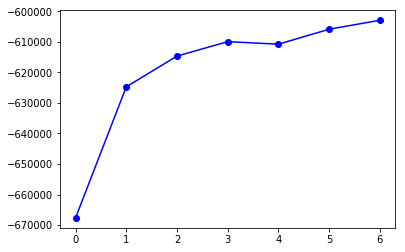

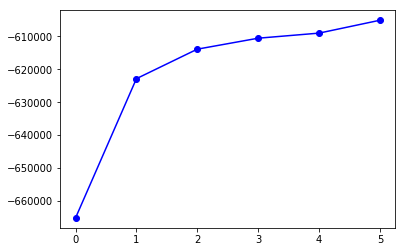

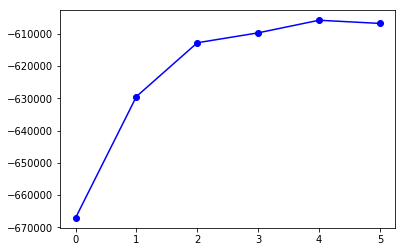

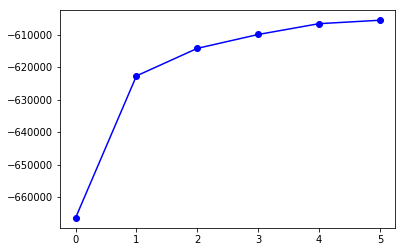

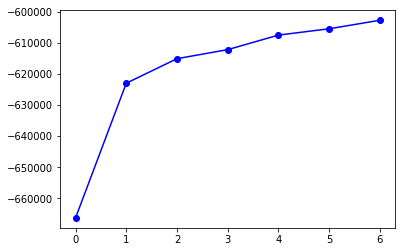

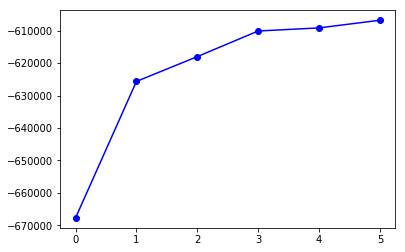

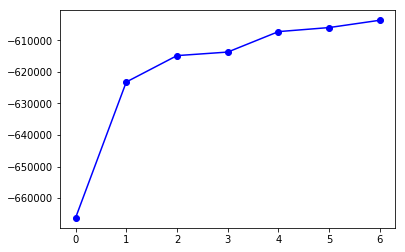

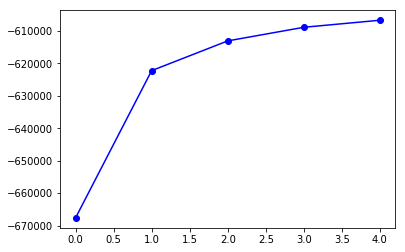

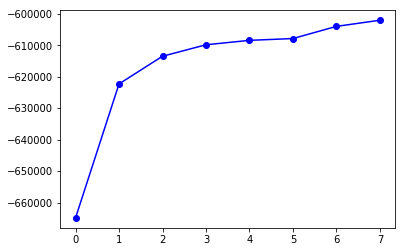

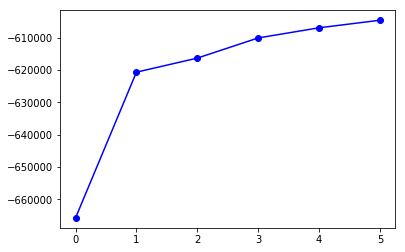

In [20]:
for value in logL_hists:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()

### Our Proposed

In [20]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 5]
 [1 3 1 ... 0 1 8]
 ...
 [1 4 0 ... 1 3 1]
 [0 2 0 ... 0 1 2]
 [0 5 0 ... 0 0 3]]
shape: (50000, 10)


In [21]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
if y_obs_categorical.shape[1] > 3000:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="tpca")[0]
else:
    annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,printed=False,mode_project="pca")[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

#mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
#aux = []
#for example in mv_soft:
#    aux.append(entropy(example)/np.log(K))
#print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Annotators PCA of annotations shape:  (100, 4)
CPU times: user 3.6 s, sys: 13 s, total: 16.6 s
Wall time: 3.24 s


In [22]:
M_seted = 4

In [23]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("default cnn")
gMixture1.lambda_random = False #lambda=1     
logL_hists,i = gMixture1.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Clustering Done!
Get init alphas in 0.009711 mins
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1. 1.]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 18.50 sec)	logL: -1002182.218	
Iter 2/50
M step: done,  E step: done //  (in 14.94 sec)	logL: -951644.805	Tol1: 0.05043	Tol2: 0.24472	Tol3: 0.03185	
Iter 3/50
M step: done,  E step: done //  (in 14.89 sec)	logL: -929154.194	Tol1: 0.02363	Tol2: 0.17505	Tol3: 0.01879	
Iter 4/50
M step: done,  E step: done //  (in 14.86 sec)	logL: -916126.898	Tol1: 0.01402	Tol2: 0.10626	Tol3: 0.00759	
Iter 5/50
M step: done,  E step: done //  (in 14.97 sec)	logL: -909313.502	Tol1: 0.00744	Tol2: 0.07471	Tol3: 0.00350	
Iter 6/50
M step: done,  E step: done //  (in 14.92 sec)	logL: -901766.337	Tol1: 0.00830	Tol2: 0.07431	Tol3: 0.00266	
Iter 7/50
M step: done,  E step: done //  (in 14.96 sec)	logL: -895729.802	Tol1: 0.00669	Tol2: 0.0656

In [24]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("default cnn")
gMixture2.lambda_random = True #lambda random
logL_hists,i = gMixture2.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Clustering Done!
Get init alphas in 0.096257 mins
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.9120997  0.8189406  0.384476   0.55571586]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 25.28 sec)	logL: -968770.372	
Iter 2/50
M step: done,  E step: done //  (in 18.22 sec)	logL: -942450.739	Tol1: 0.02717	Tol2: 0.19333	Tol3: 0.03838	
Iter 3/50
M step: done,  E step: done //  (in 18.51 sec)	logL: -918047.151	Tol1: 0.02589	Tol2: 0.12009	Tol3: 0.02146	
Iter 4/50
M step: done,  E step: done //  (in 18.42 sec)	logL: -915304.459	Tol1: 0.00299	Tol2: 0.09369	Tol3: 0.00538	
Iter 5/50
M step: done,  E step: done //  (in 19.20 sec)	logL: -899655.103	Tol1: 0.01710	Tol2: 0.12959	Tol3: 0.00189	
Iter 6/50
M step: done,  E step: done //  (in 17.73 sec)	logL: -900474.057	Tol1: 0.00091	Tol2: 0.07310	Tol3: 0.00307	
Iter 7/50
M step: done,  E step: done //  (in 19.21 sec)	logL: -890969

In [29]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("default cnn")
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i = gMixture3.multiples_run(10,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Clustering Done!
Get init alphas in 5.713441 mins
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.6754016  0.17243214 0.6680317  0.12098361]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done,  E step: done //  (in 26.76 sec)	logL: -969108.079	
Iter 2/50
M step: done,  E step: done //  (in 16.61 sec)	logL: -936567.173	Tol1: 0.03358	Tol2: 0.16567	Tol3: 0.01990	
Iter 3/50
M step: done,  E step: done //  (in 18.56 sec)	logL: -920032.771	Tol1: 0.01765	Tol2: 0.14935	Tol3: 0.01271	
Iter 4/50
M step: done,  E step: done //  (in 16.61 sec)	logL: -911370.219	Tol1: 0.00942	Tol2: 0.10072	Tol3: 0.00261	
Iter 5/50
M step: done,  E step: done //  (in 16.58 sec)	logL: -919674.204	Tol1: 0.00911	Tol2: 0.12033	Tol3: 0.00889	
Iter 6/50
M step: done,  E step: done //  (in 16.57 sec)	logL: -902081.734	Tol1: 0.01913	Tol2: 0.19796	Tol3: 0.01365	
Iter 7/50
M step: done,  E step: done //  (in 16.59 sec)	logL: -893671

### Compare trained models

In [15]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [22]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound -- Ideal (Train with GT) ***")

print("Train")
Z_train_pred = evaluate.tested_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = evaluate.tested_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.98448 |      0.98448 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.8084 |       0.8084 |
+----+--------+------------+--------------+


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [44]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.84344


*** Soft-Majority (Train with softMV) ***
Train


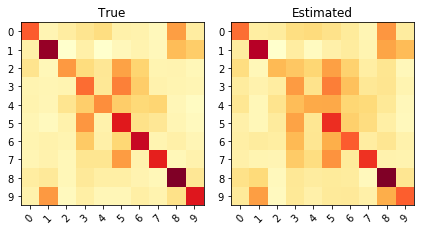

KL divergence: 0.0642	Pearson Correlation between diagonals: 0.9398


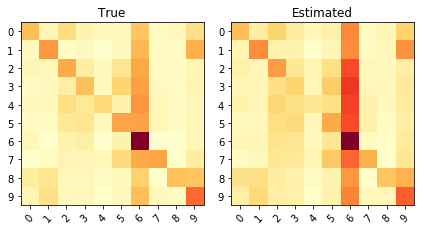

KL divergence: 0.0643	Pearson Correlation between diagonals: 0.9855


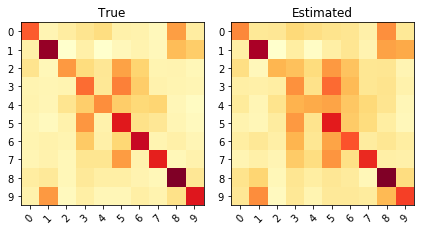

KL divergence: 0.0661	Pearson Correlation between diagonals: 0.9542


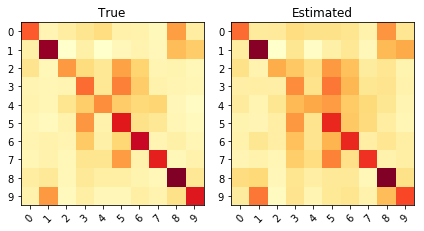

KL divergence: 0.0609	Pearson Correlation between diagonals: 0.9781


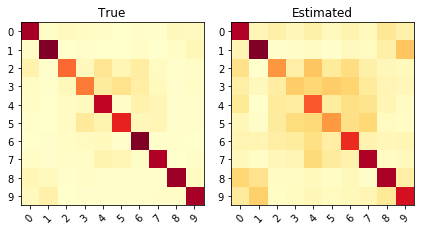

KL divergence: 0.3111	Pearson Correlation between diagonals: 0.8826


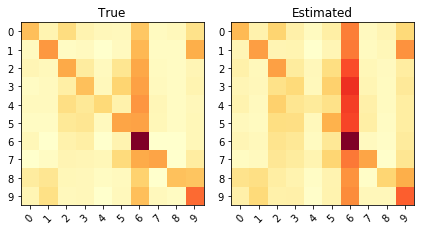

KL divergence: 0.0644	Pearson Correlation between diagonals: 0.9828


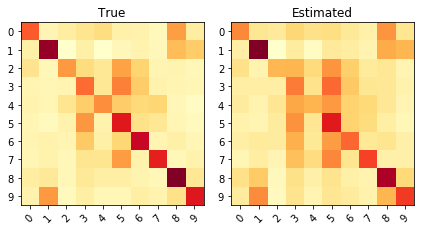

KL divergence: 0.0689	Pearson Correlation between diagonals: 0.9223


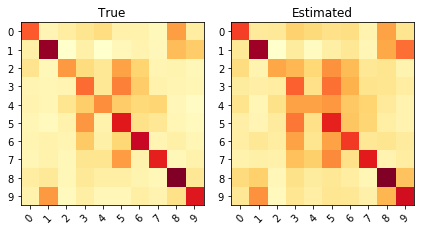

KL divergence: 0.0698	Pearson Correlation between diagonals: 0.9415


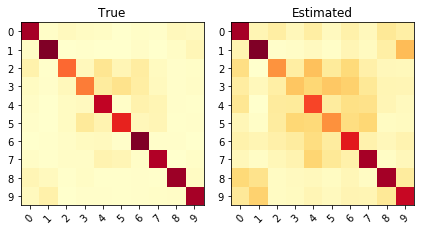

KL divergence: 0.3041	Pearson Correlation between diagonals: 0.9020


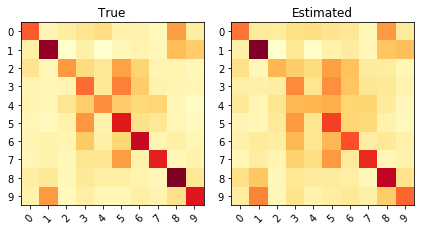

KL divergence: 0.0653	Pearson Correlation between diagonals: 0.9224


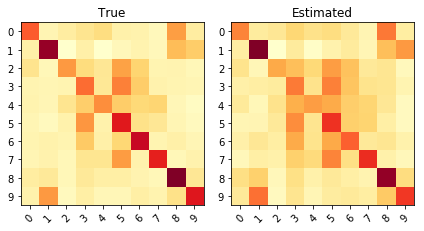

KL divergence: 0.0656	Pearson Correlation between diagonals: 0.9269


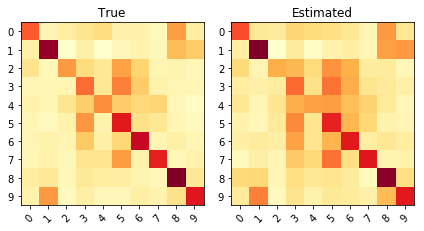

KL divergence: 0.0584	Pearson Correlation between diagonals: 0.9755


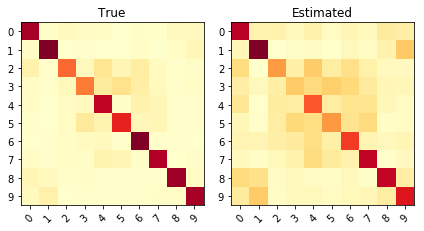

KL divergence: 0.3099	Pearson Correlation between diagonals: 0.8770


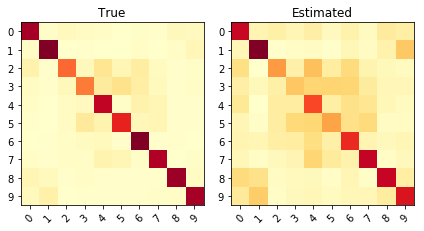

KL divergence: 0.3109	Pearson Correlation between diagonals: 0.9016


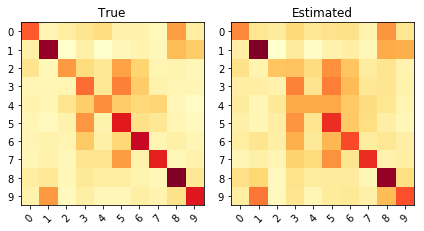

KL divergence: 0.0643	Pearson Correlation between diagonals: 0.9522
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |    0.86584 |      0.86584 |     0.145495 |              0.938672 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.7235 |       0.7235 |
+----+--------+------------+--------------+


In [45]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


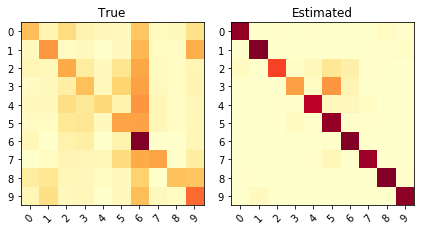

KL divergence: 0.8369	Pearson Correlation between diagonals: 0.3171


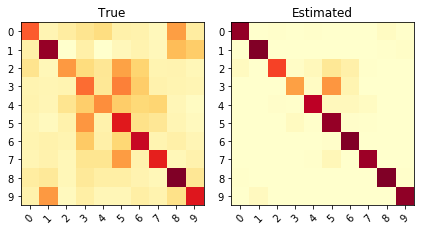

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


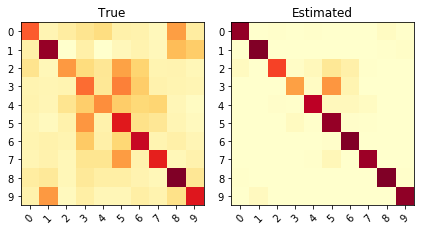

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


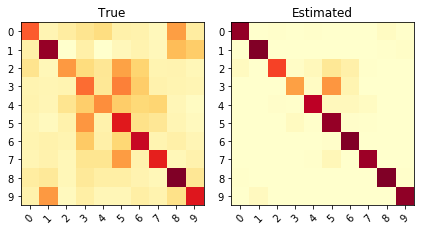

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


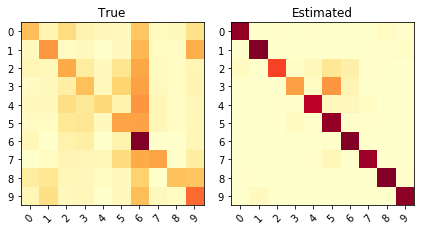

KL divergence: 0.8369	Pearson Correlation between diagonals: 0.3171


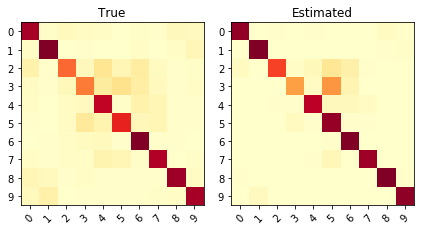

KL divergence: 1.2778	Pearson Correlation between diagonals: 0.8984


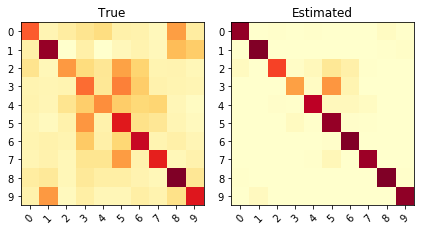

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


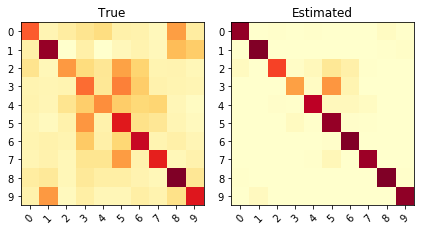

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


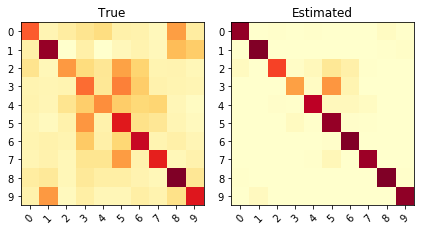

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


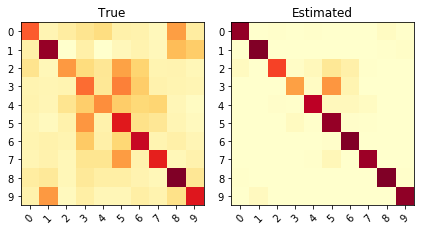

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


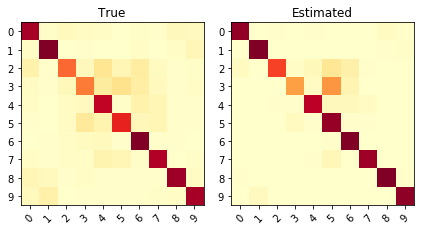

KL divergence: 1.2778	Pearson Correlation between diagonals: 0.8984


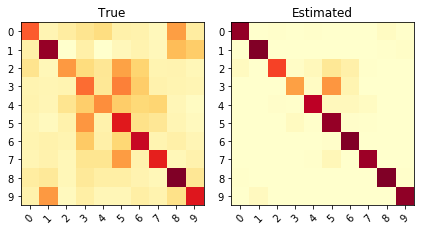

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


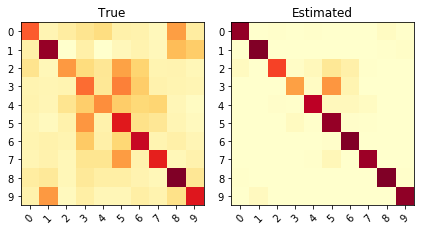

KL divergence: 0.7930	Pearson Correlation between diagonals: 0.6498


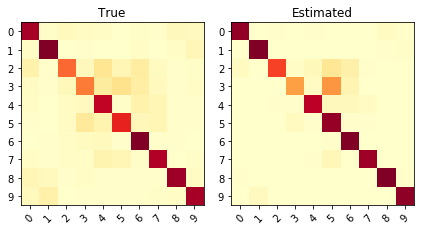

KL divergence: 1.2778	Pearson Correlation between diagonals: 0.8984


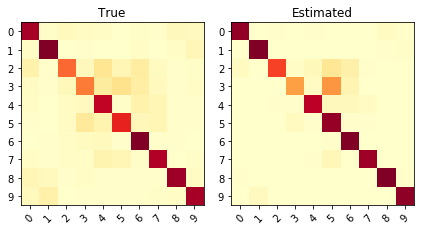

KL divergence: 1.2778	Pearson Correlation between diagonals: 0.8984
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |    0.86584 |      0.86584 |     0.979693 |              0.689836 |
+----+--------+------------+--------------+--------------+-----------------------+


In [46]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


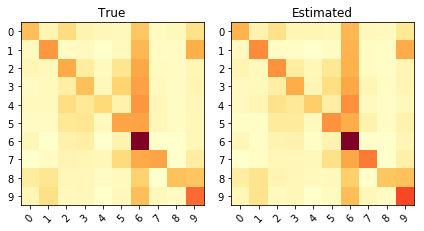

KL divergence: 0.0159	Pearson Correlation between diagonals: 0.9829


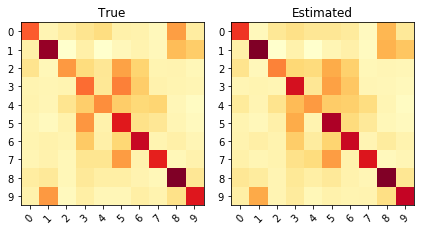

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9045


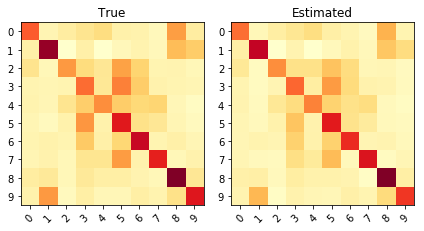

KL divergence: 0.0111	Pearson Correlation between diagonals: 0.9505


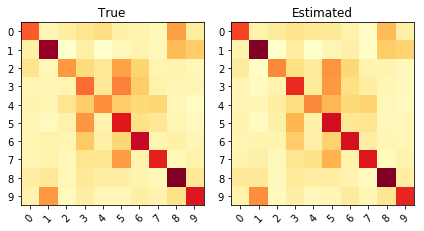

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9560


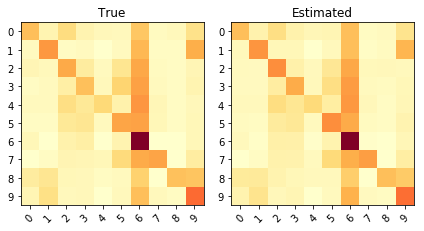

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9830


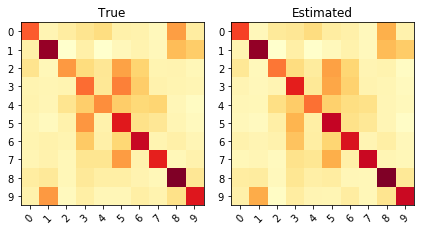

KL divergence: 0.0110	Pearson Correlation between diagonals: 0.9425


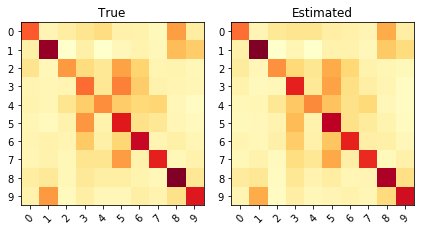

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.8834


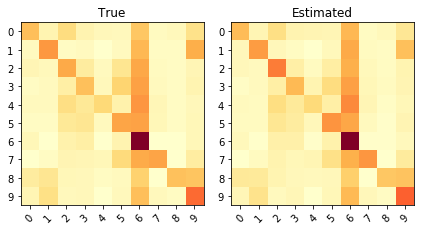

KL divergence: 0.0146	Pearson Correlation between diagonals: 0.9763


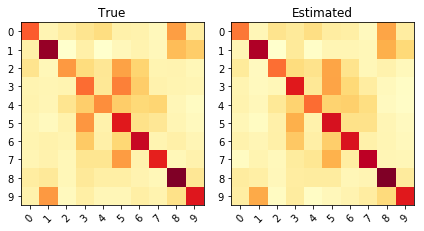

KL divergence: 0.0167	Pearson Correlation between diagonals: 0.8838


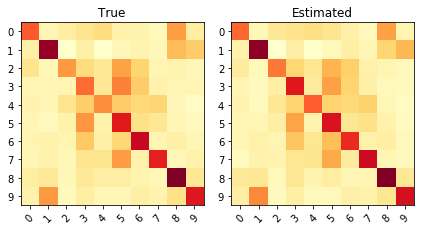

KL divergence: 0.0156	Pearson Correlation between diagonals: 0.8867


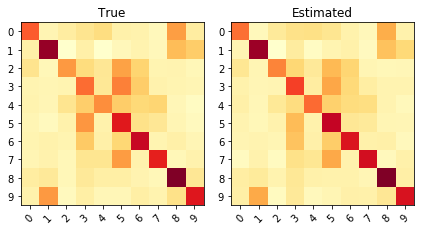

KL divergence: 0.0147	Pearson Correlation between diagonals: 0.9542


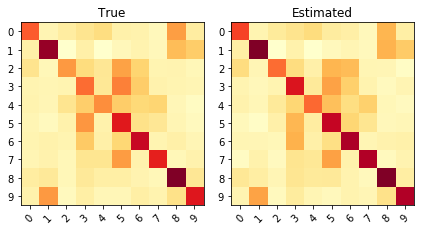

KL divergence: 0.0148	Pearson Correlation between diagonals: 0.9464


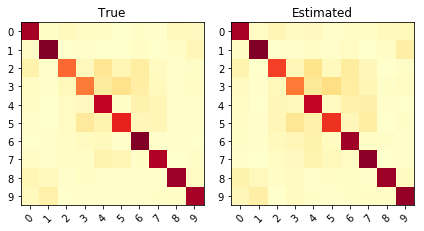

KL divergence: 0.0220	Pearson Correlation between diagonals: 0.9596


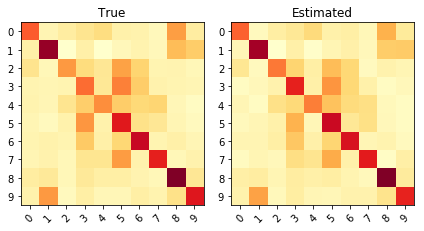

KL divergence: 0.0148	Pearson Correlation between diagonals: 0.9367


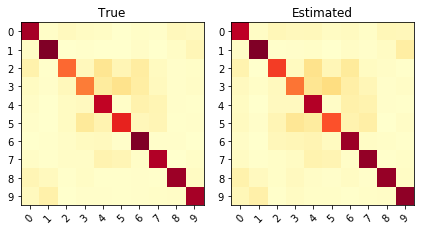

KL divergence: 0.0244	Pearson Correlation between diagonals: 0.9327
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |     0.8471 |       0.8471 |    0.0171683 |              0.945224 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |      0.719 |        0.719 |
+----+--------+------------+--------------+


In [47]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


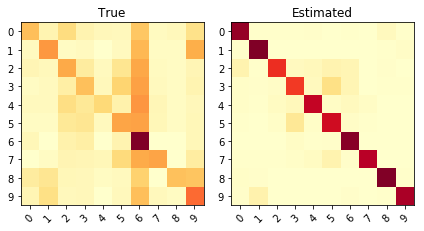

KL divergence: 0.5724	Pearson Correlation between diagonals: 0.3608


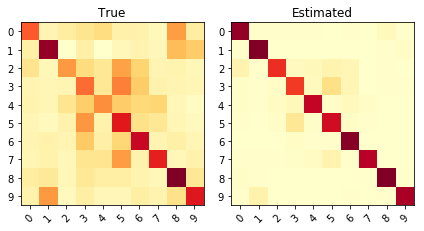

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


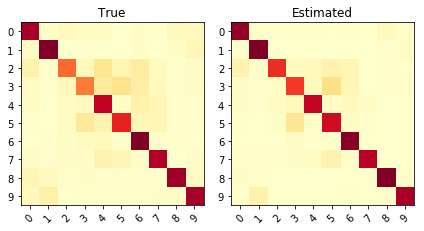

KL divergence: 1.3066	Pearson Correlation between diagonals: 0.9731


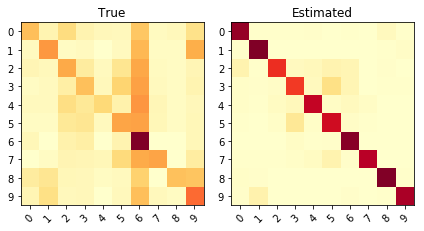

KL divergence: 0.5724	Pearson Correlation between diagonals: 0.3608


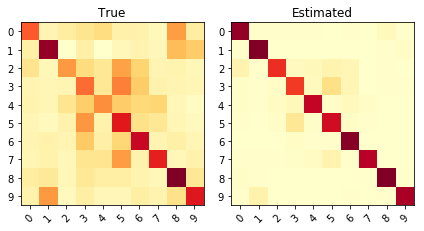

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


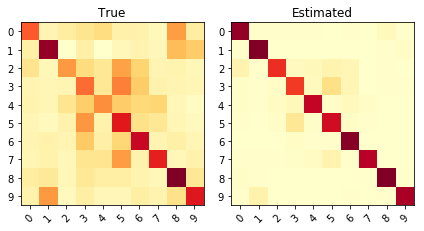

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


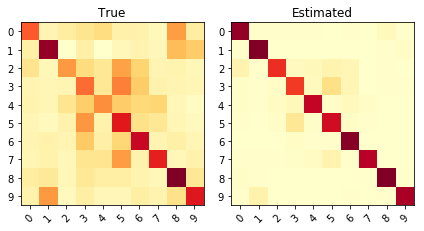

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


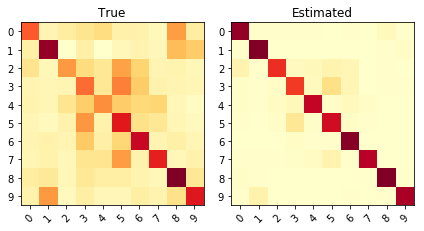

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


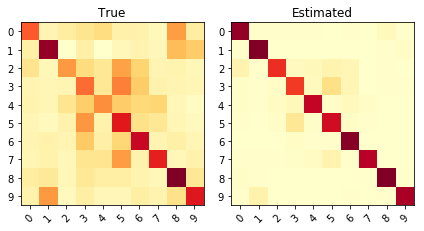

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


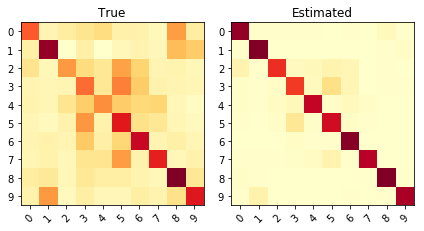

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510


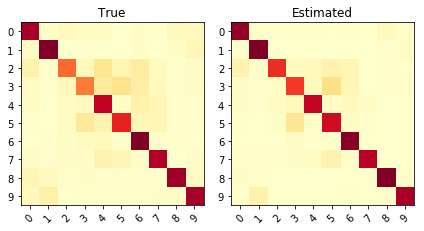

KL divergence: 1.3066	Pearson Correlation between diagonals: 0.9731


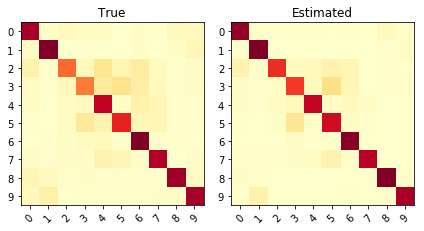

KL divergence: 1.3066	Pearson Correlation between diagonals: 0.9731


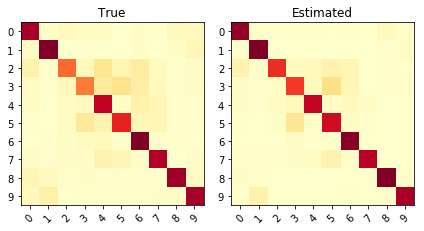

KL divergence: 1.3066	Pearson Correlation between diagonals: 0.9731


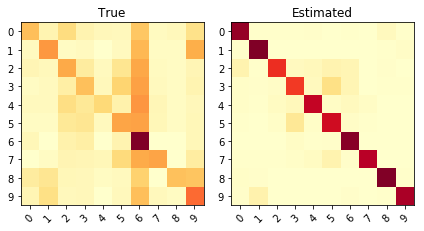

KL divergence: 0.5724	Pearson Correlation between diagonals: 0.3608


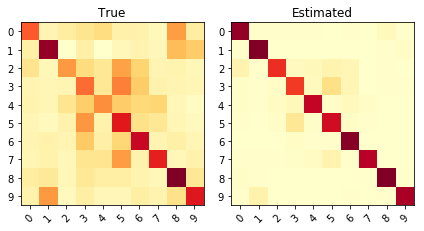

KL divergence: 0.4076	Pearson Correlation between diagonals: 0.7510
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |     0.8471 |       0.8471 |     0.740254 |              0.763337 |
+----+--------+------------+--------------+--------------+-----------------------+


In [48]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


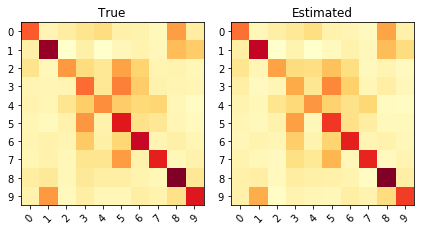

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9634


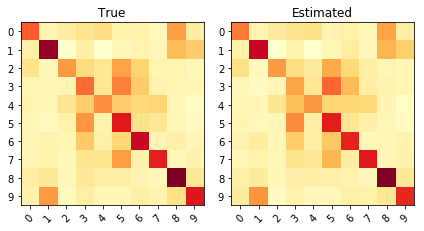

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9583


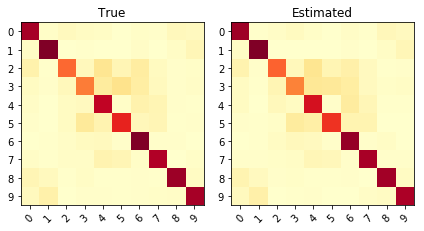

KL divergence: 0.0249	Pearson Correlation between diagonals: 0.9868


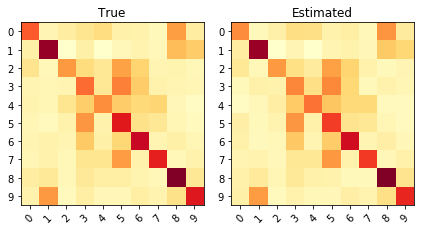

KL divergence: 0.0110	Pearson Correlation between diagonals: 0.9675


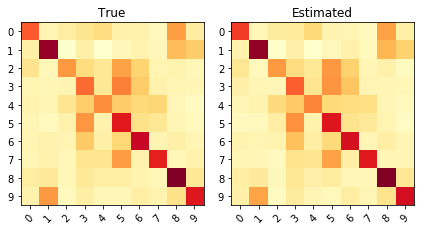

KL divergence: 0.0066	Pearson Correlation between diagonals: 0.9887


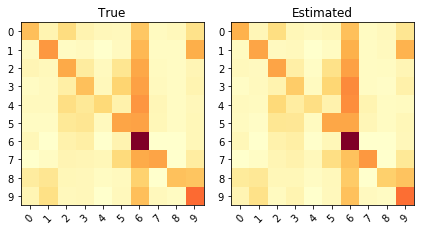

KL divergence: 0.0093	Pearson Correlation between diagonals: 0.9884


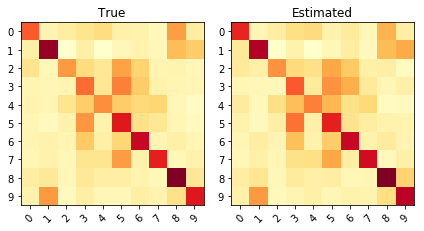

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9535


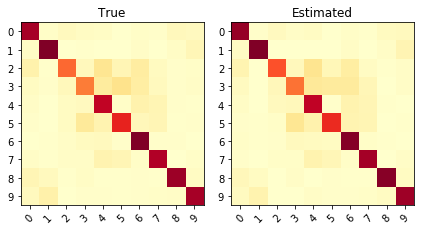

KL divergence: 0.0173	Pearson Correlation between diagonals: 0.9904


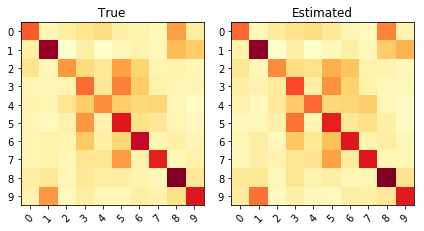

KL divergence: 0.0128	Pearson Correlation between diagonals: 0.9693


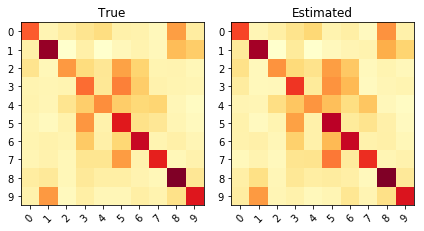

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9499


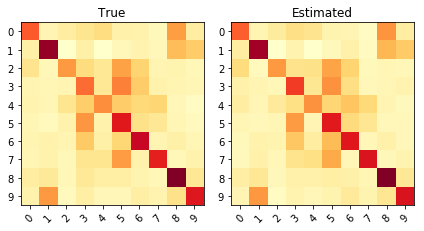

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9684


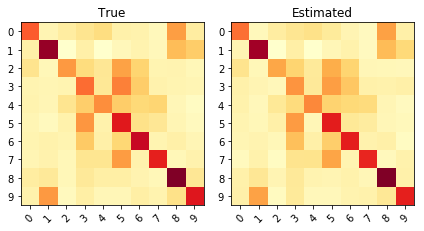

KL divergence: 0.0101	Pearson Correlation between diagonals: 0.9815


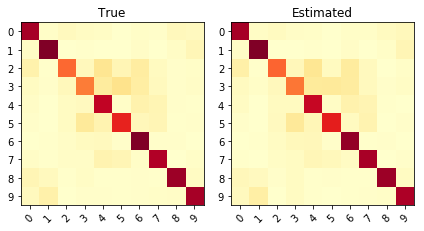

KL divergence: 0.0270	Pearson Correlation between diagonals: 0.9958


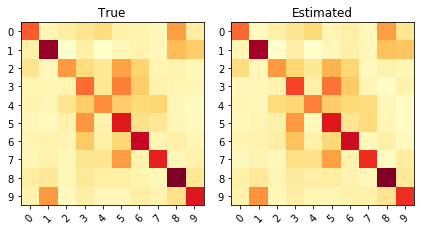

KL divergence: 0.0133	Pearson Correlation between diagonals: 0.9775


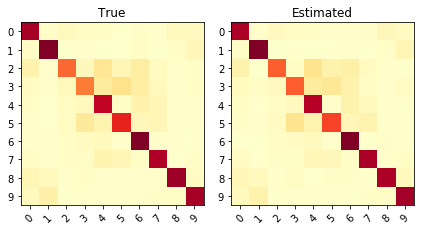

KL divergence: 0.0298	Pearson Correlation between diagonals: 0.9745
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |    0.92448 |      0.92448 |    0.0142585 |              0.979194 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.7816 |       0.7816 |
+----+--------+------------+--------------+


In [49]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


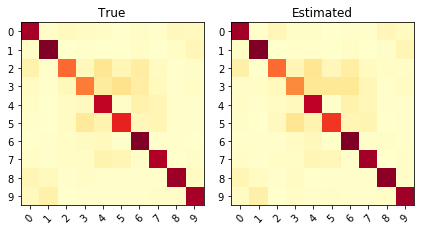

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9944


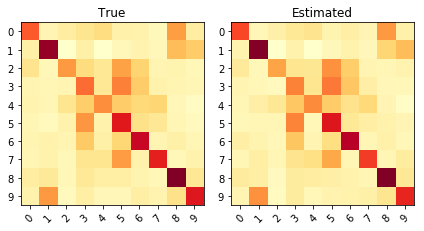

KL divergence: 0.0111	Pearson Correlation between diagonals: 0.9806


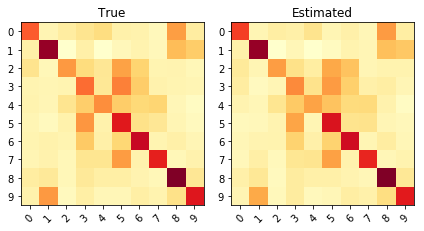

KL divergence: 0.0089	Pearson Correlation between diagonals: 0.9824


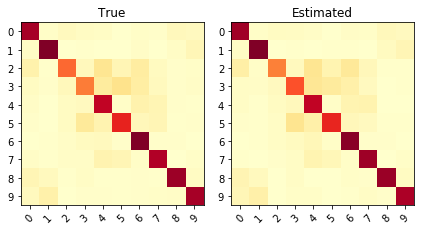

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9773


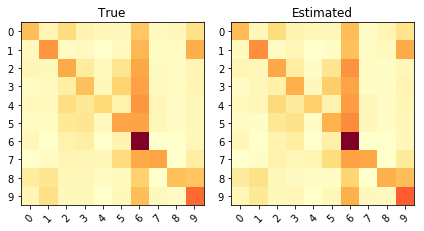

KL divergence: 0.0110	Pearson Correlation between diagonals: 0.9910


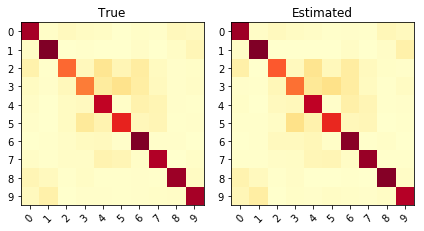

KL divergence: 0.0105	Pearson Correlation between diagonals: 0.9871


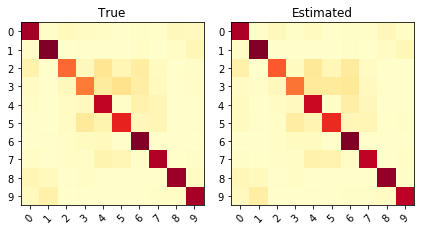

KL divergence: 0.0096	Pearson Correlation between diagonals: 0.9893


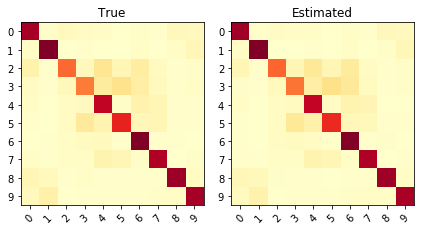

KL divergence: 0.0073	Pearson Correlation between diagonals: 0.9984


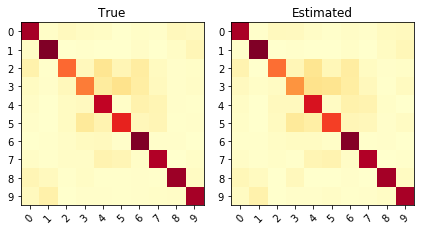

KL divergence: 0.0110	Pearson Correlation between diagonals: 0.9909


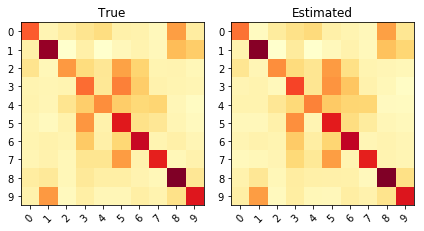

KL divergence: 0.0089	Pearson Correlation between diagonals: 0.9823


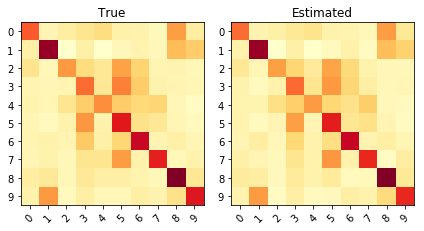

KL divergence: 0.0091	Pearson Correlation between diagonals: 0.9964


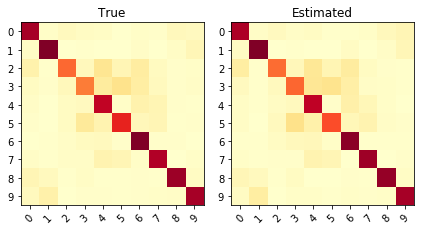

KL divergence: 0.0118	Pearson Correlation between diagonals: 0.9722


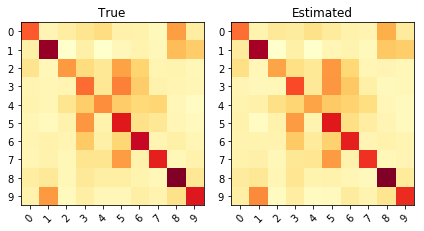

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9689


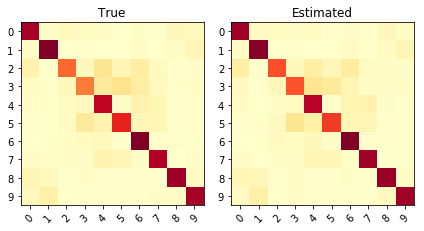

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9763


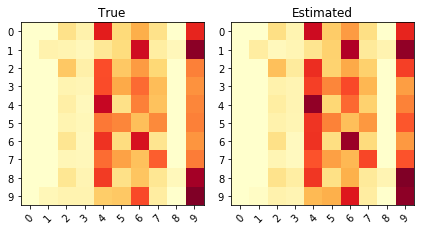

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9919
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.81974       0.81974     0.0104165               0.982287       0.0596261
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.448193                 1.62201
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global      0.7648        0.7648
====  =====

In [28]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


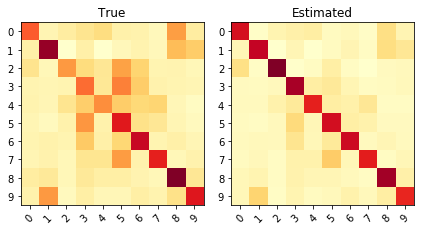

KL divergence: 0.1473	Pearson Correlation between diagonals: -0.0626


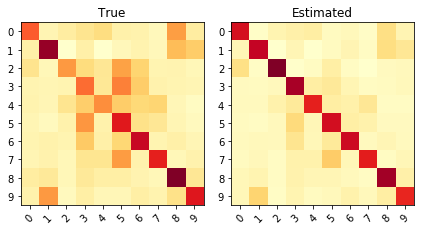

KL divergence: 0.1473	Pearson Correlation between diagonals: -0.0626


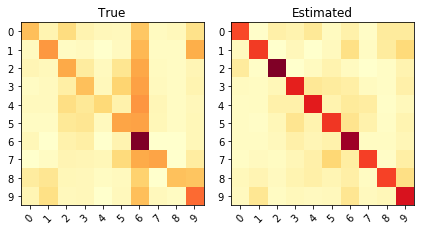

KL divergence: 0.3046	Pearson Correlation between diagonals: 0.5204


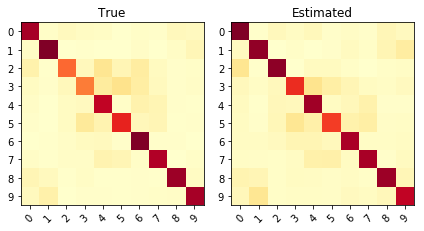

KL divergence: 0.0944	Pearson Correlation between diagonals: 0.5111


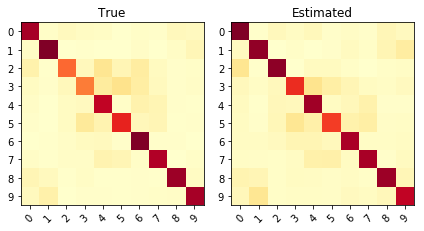

KL divergence: 0.0944	Pearson Correlation between diagonals: 0.5111


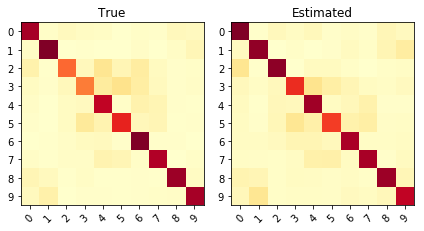

KL divergence: 0.0944	Pearson Correlation between diagonals: 0.5111


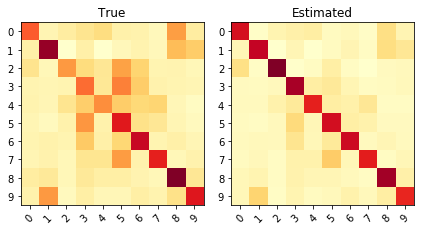

KL divergence: 0.1473	Pearson Correlation between diagonals: -0.0626


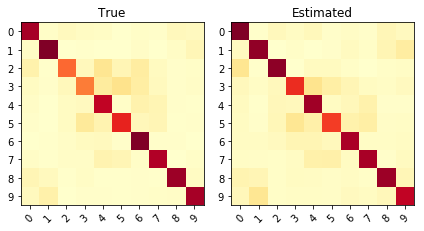

KL divergence: 0.0944	Pearson Correlation between diagonals: 0.5111


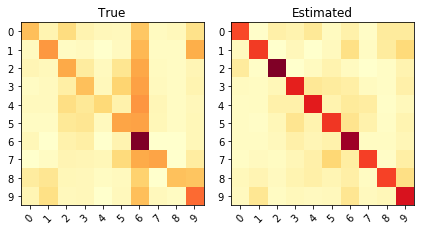

KL divergence: 0.3046	Pearson Correlation between diagonals: 0.5204


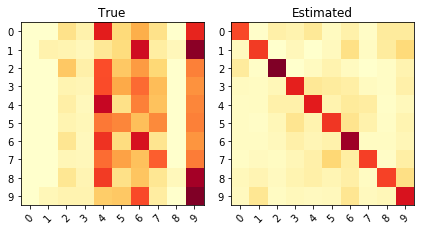

KL divergence: 0.6956	Pearson Correlation between diagonals: 0.3612


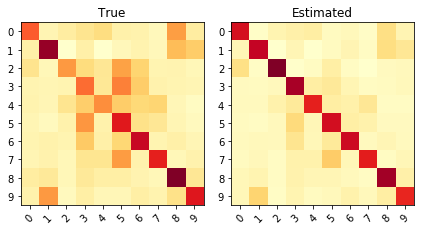

KL divergence: 0.1473	Pearson Correlation between diagonals: -0.0626


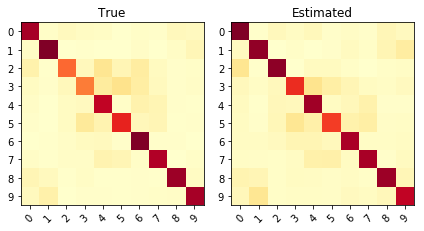

KL divergence: 0.0944	Pearson Correlation between diagonals: 0.5111


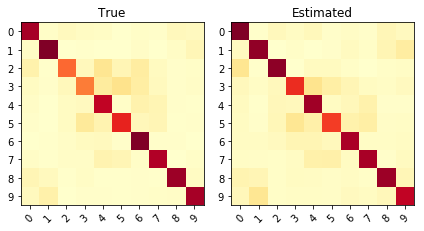

KL divergence: 0.0944	Pearson Correlation between diagonals: 0.5111


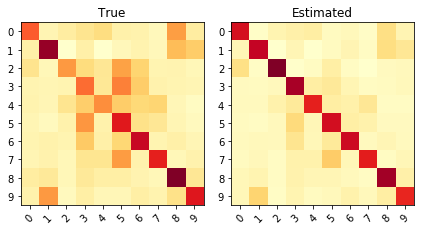

KL divergence: 0.1473	Pearson Correlation between diagonals: -0.0626


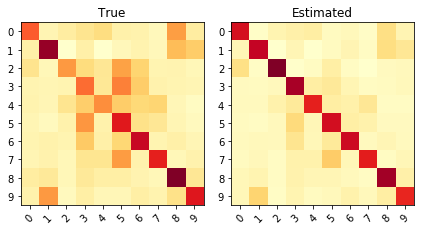

KL divergence: 0.1473	Pearson Correlation between diagonals: -0.0626
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.84736       0.84736      0.171624               0.215923       0.0226875
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.468484                 1.63456
====  =======================  ======================
Test


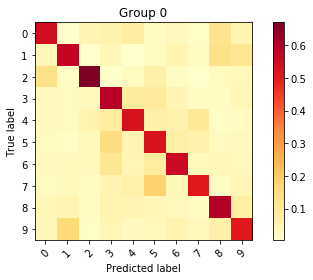

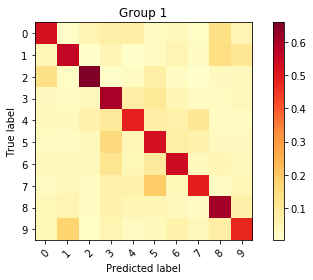

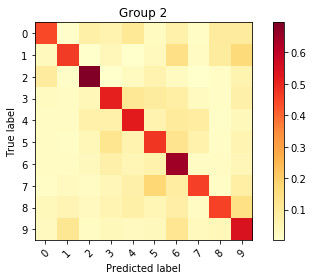

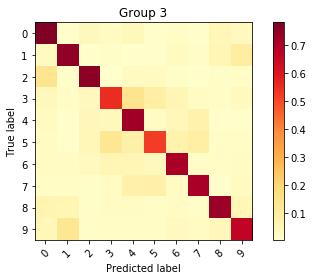

Inertia: 0.015516900229461802
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.19944       19    1.54966     0.558987   0.585147            0.73296       0.7837        0.7837
   1         1  0.190793      19    1.56705     0.548157   0.606502            0.724457      0.7797        0.7797
   2         2  0.224666      22    1.61573     0.522799   0.65972             0.703716      0.7701        0.7701
   3         3  0.385102      38    1.18952     0.6924     0.375706            0.823617      0.7779        0.7779
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============

In [25]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


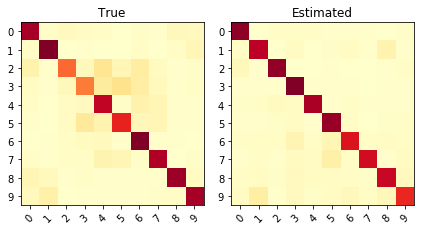

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.6925


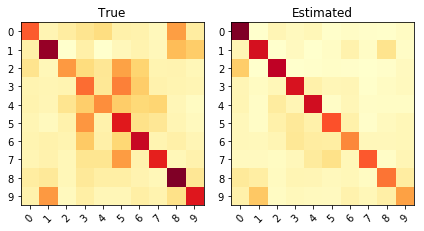

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


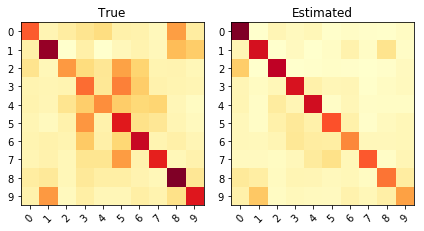

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


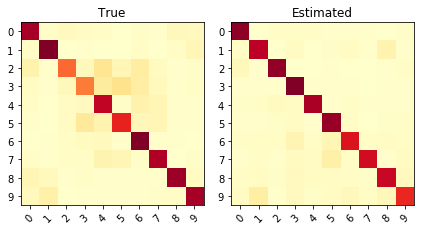

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.6925


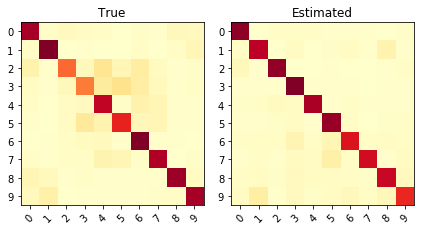

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.6925


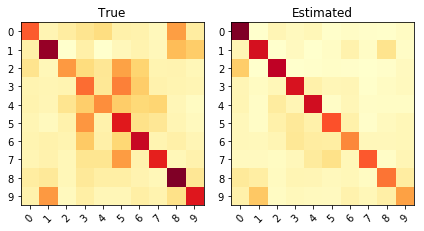

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


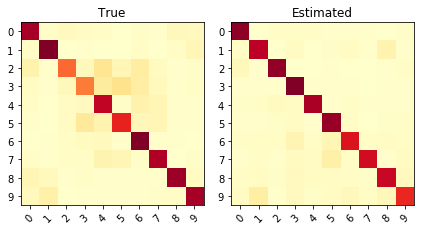

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.6925


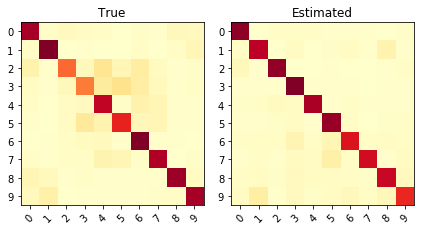

KL divergence: 0.3096	Pearson Correlation between diagonals: -0.6925


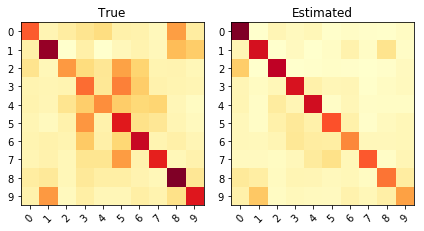

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


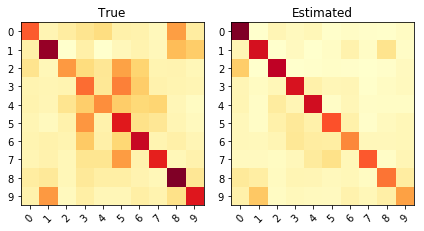

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


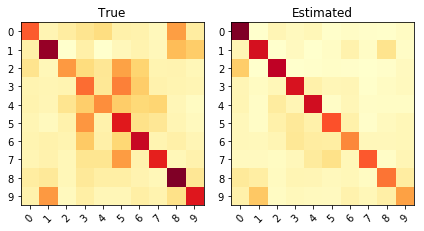

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


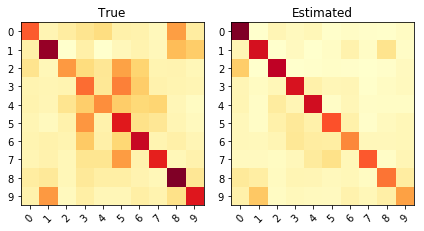

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


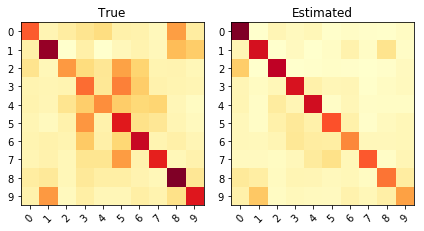

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


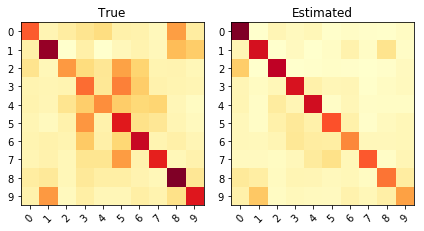

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892


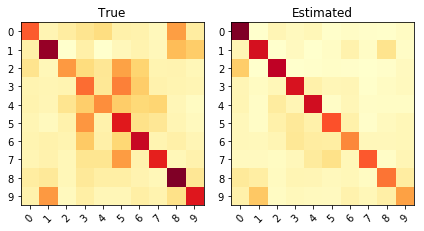

KL divergence: 0.4583	Pearson Correlation between diagonals: -0.5892
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.84256       0.84256       0.48518              -0.594678       0.0197056
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.471576                 1.66654
====  =======================  ======================
Test


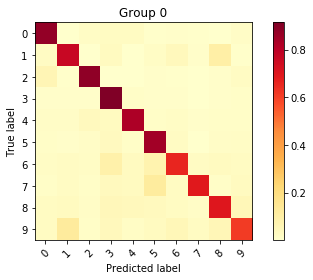

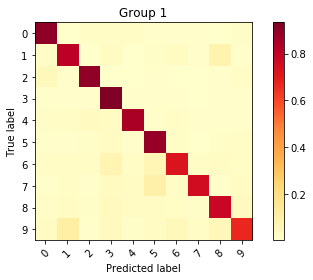

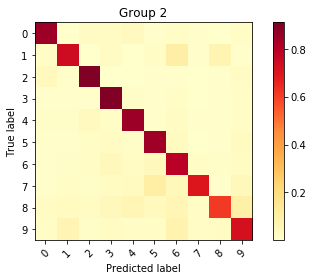

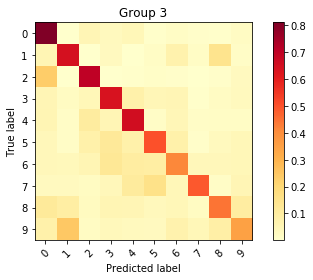

Inertia: 0.02423088380601257
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.207756      20   0.93583      0.7774     0.260561            0.875891      0.7581        0.7581
   1         1  0.198027      19   0.792717     0.822579   0.2005              0.903384      0.7529        0.7529
   2         2  0.236672      23   0.878403     0.795452   0.236032            0.887051      0.7463        0.7463
   3         3  0.357544      35   1.46341      0.565443   0.601529            0.730658      0.777         0.777
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
 

In [26]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


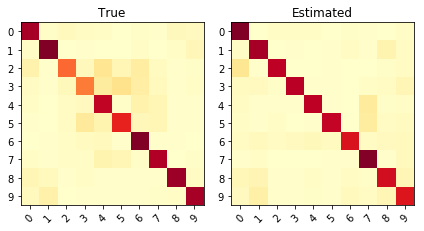

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


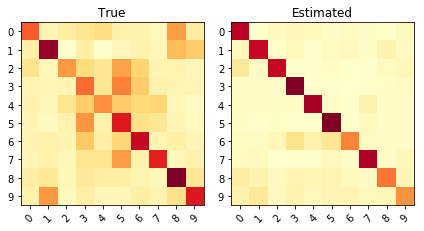

KL divergence: 0.6953	Pearson Correlation between diagonals: -0.5346


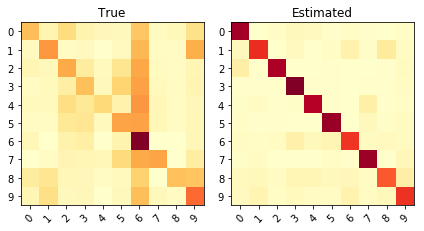

KL divergence: 1.4149	Pearson Correlation between diagonals: -0.4540


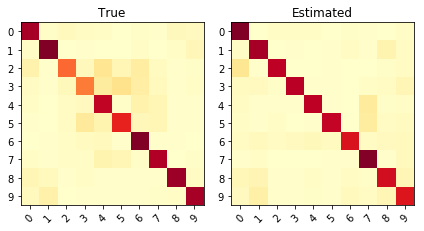

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


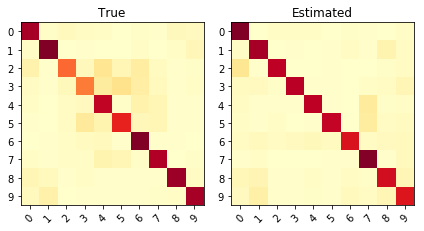

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


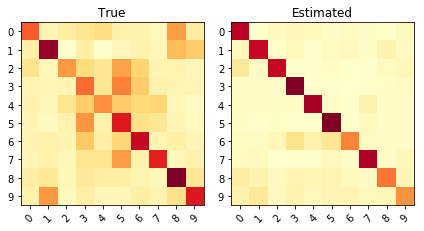

KL divergence: 0.6953	Pearson Correlation between diagonals: -0.5346


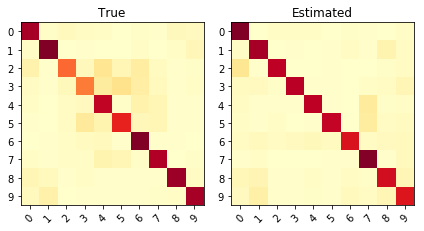

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


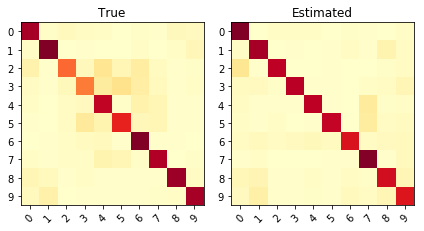

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


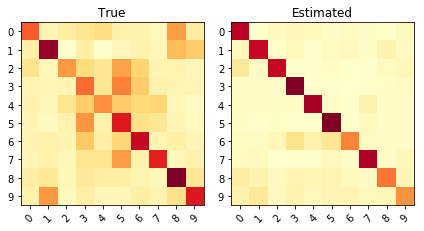

KL divergence: 0.6953	Pearson Correlation between diagonals: -0.5346


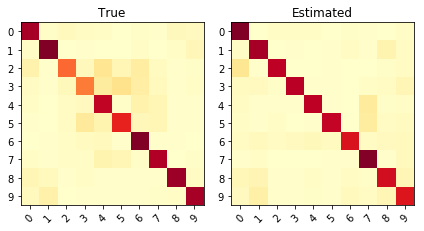

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


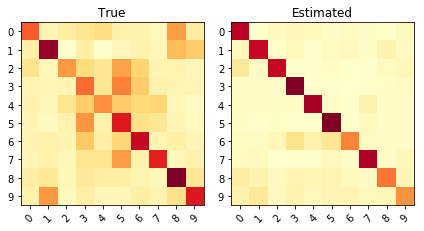

KL divergence: 0.6953	Pearson Correlation between diagonals: -0.5346


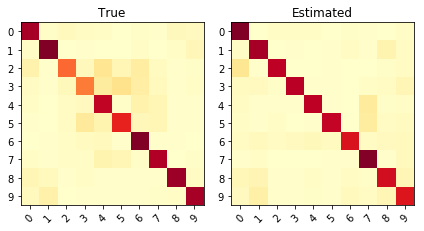

KL divergence: 0.3827	Pearson Correlation between diagonals: -0.0247


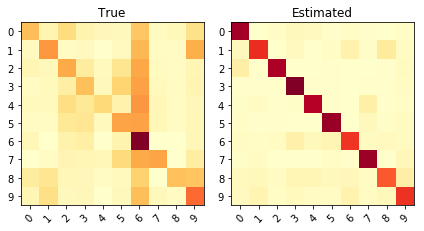

KL divergence: 1.4149	Pearson Correlation between diagonals: -0.4540


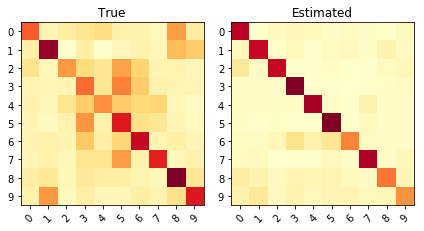

KL divergence: 0.6953	Pearson Correlation between diagonals: -0.5346


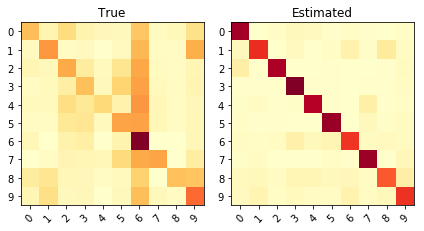

KL divergence: 1.4149	Pearson Correlation between diagonals: -0.4540
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.84692       0.84692      0.657124              -0.322313       0.0185487
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.47597                 1.65284
====  =======================  ======================
Test


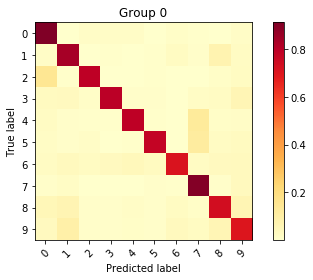

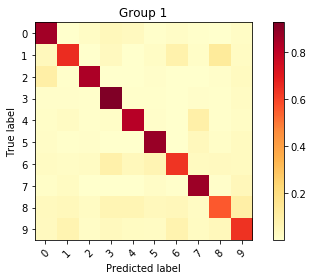

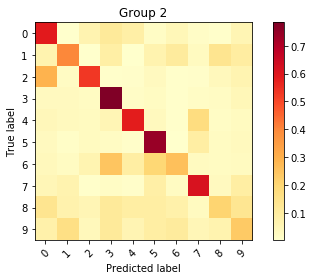

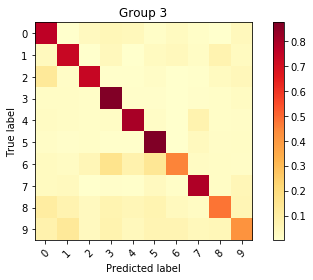

Inertia: 0.035402329793820776
A result
 ====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.366214       36   0.842822     0.796579   0.231007            0.888821      0.7486        0.7486
   1         1  0.466019       46   0.938017     0.766033   0.280562            0.867513      0.7558        0.7558
   2         2  0.0751438       7   1.56961      0.495515   0.799612            0.664068      0.7329        0.7329
   3         3  0.092623        9   1.16365      0.691352   0.401978            0.816091      0.758         0.758
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  =====

In [30]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.63474


*** Soft-Majority (Train with softMV) ***
Train


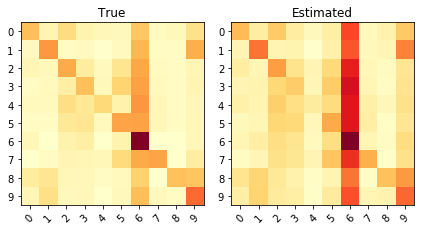

KL divergence: 0.0949	Pearson Correlation between diagonals: 0.9762


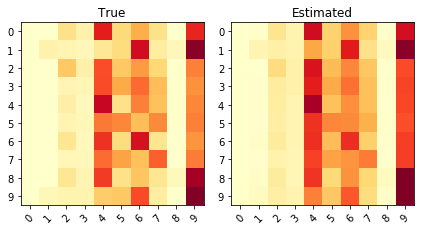

KL divergence: 0.0247	Pearson Correlation between diagonals: 0.9910


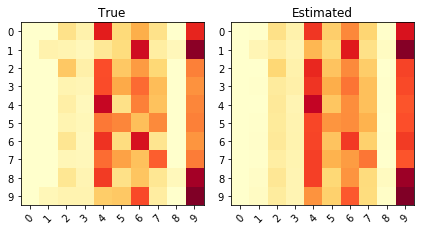

KL divergence: 0.0251	Pearson Correlation between diagonals: 0.9936


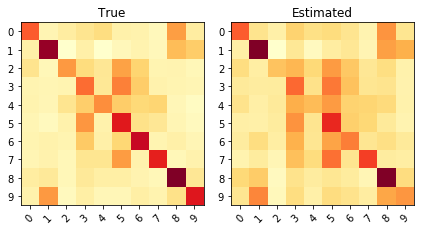

KL divergence: 0.1019	Pearson Correlation between diagonals: 0.8488


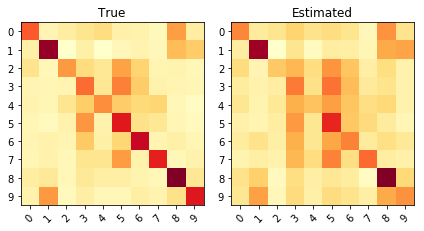

KL divergence: 0.0997	Pearson Correlation between diagonals: 0.8777


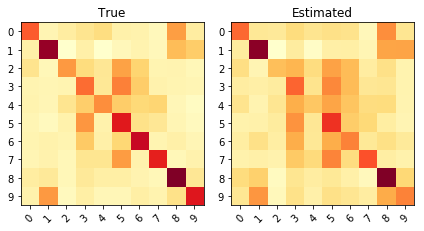

KL divergence: 0.0973	Pearson Correlation between diagonals: 0.8659


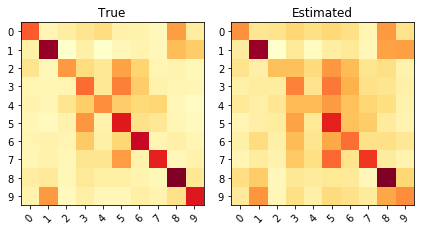

KL divergence: 0.1035	Pearson Correlation between diagonals: 0.9008


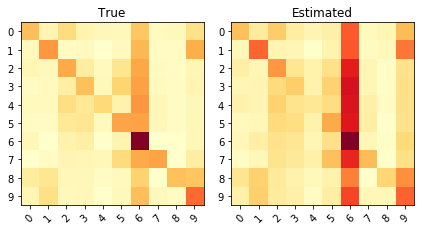

KL divergence: 0.0986	Pearson Correlation between diagonals: 0.9659


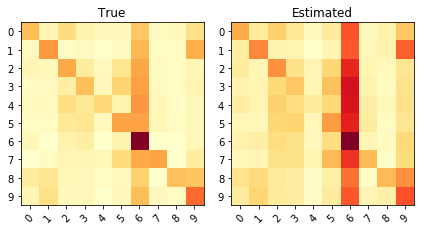

KL divergence: 0.0948	Pearson Correlation between diagonals: 0.9648


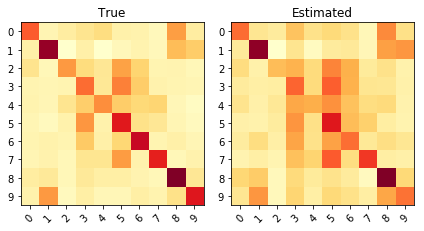

KL divergence: 0.1011	Pearson Correlation between diagonals: 0.8868


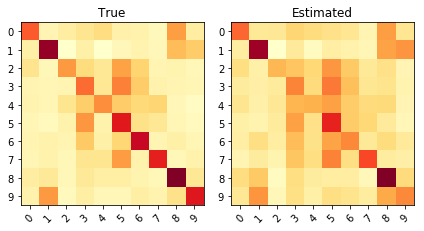

KL divergence: 0.1039	Pearson Correlation between diagonals: 0.8657


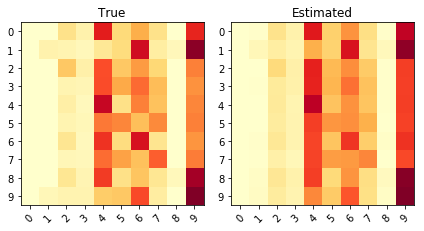

KL divergence: 0.0251	Pearson Correlation between diagonals: 0.9924


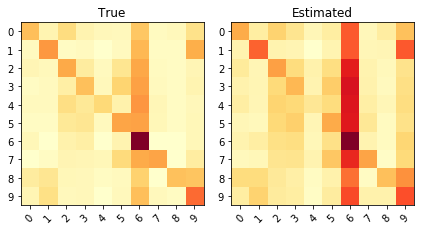

KL divergence: 0.0983	Pearson Correlation between diagonals: 0.9713


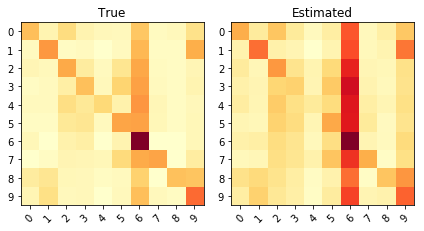

KL divergence: 0.1018	Pearson Correlation between diagonals: 0.9676


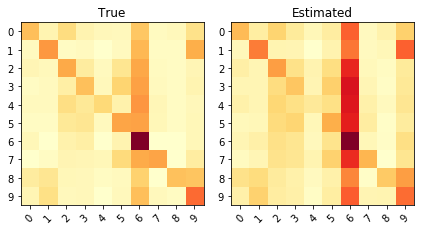

KL divergence: 0.0904	Pearson Correlation between diagonals: 0.9806
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |      0.701 |        0.701 |     0.117743 |               0.92338 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |      0.586 |        0.586 |
+----+--------+------------+--------------+


In [24]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


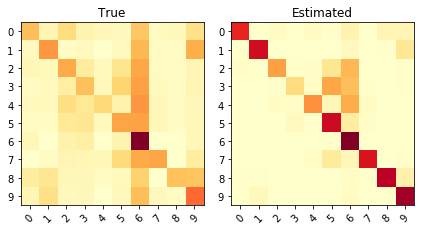

KL divergence: 0.6738	Pearson Correlation between diagonals: 0.5852


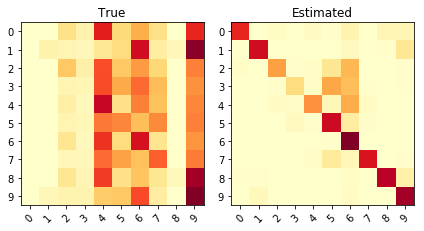

KL divergence: 0.7161	Pearson Correlation between diagonals: 0.3208


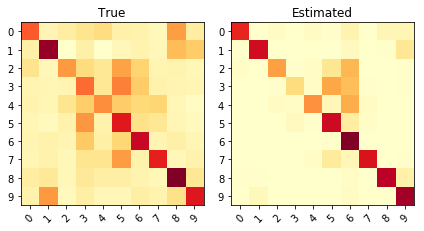

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


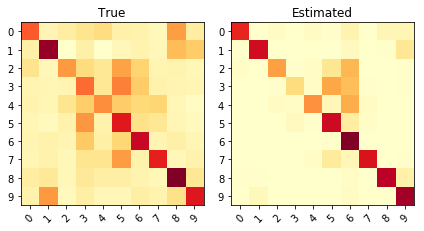

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


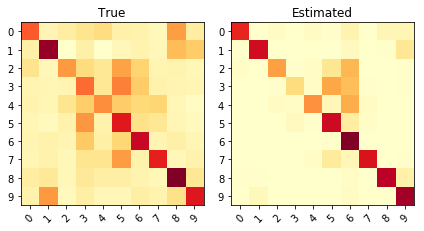

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


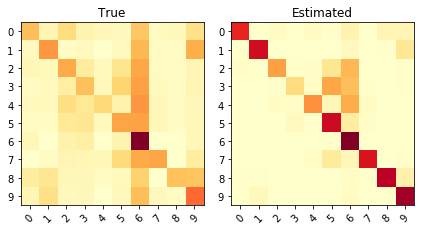

KL divergence: 0.6738	Pearson Correlation between diagonals: 0.5852


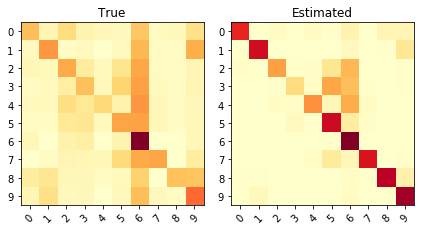

KL divergence: 0.6738	Pearson Correlation between diagonals: 0.5852


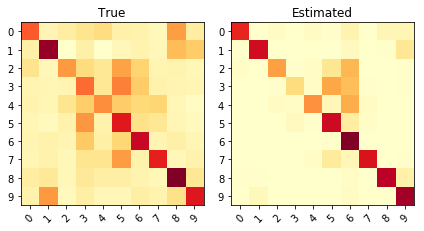

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


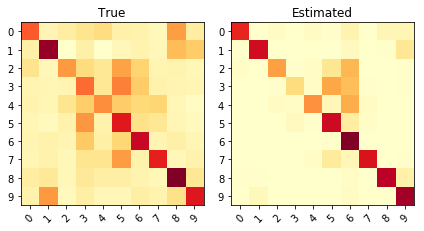

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


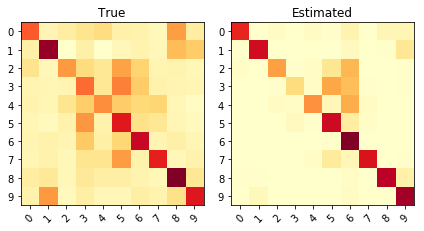

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


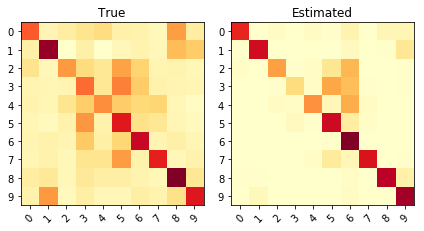

KL divergence: 0.7261	Pearson Correlation between diagonals: 0.7664


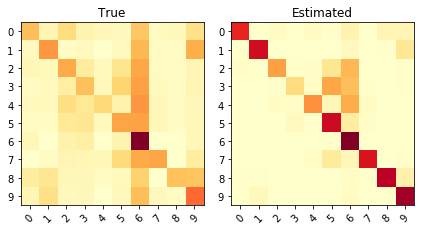

KL divergence: 0.6738	Pearson Correlation between diagonals: 0.5852


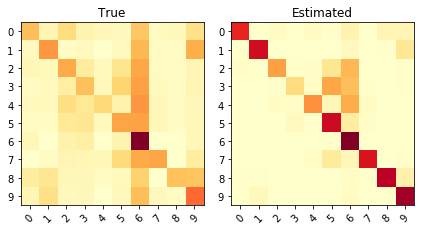

KL divergence: 0.6738	Pearson Correlation between diagonals: 0.5852


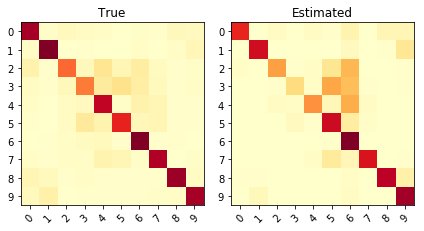

KL divergence: 1.2703	Pearson Correlation between diagonals: 0.8216


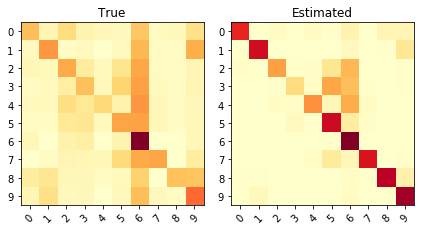

KL divergence: 0.6738	Pearson Correlation between diagonals: 0.5852
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |      0.701 |        0.701 |      0.75488 |               0.62329 |
+----+--------+------------+--------------+--------------+-----------------------+


In [25]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


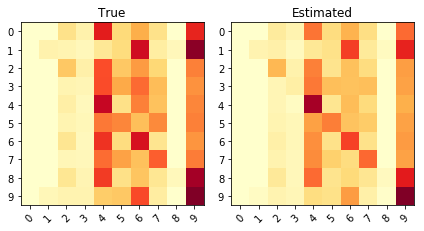

KL divergence: 0.0166	Pearson Correlation between diagonals: 0.9878


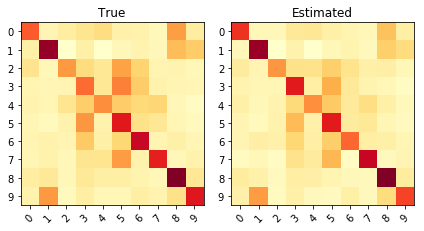

KL divergence: 0.0274	Pearson Correlation between diagonals: 0.7721


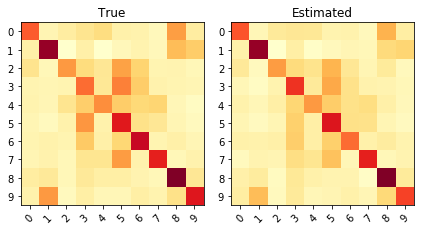

KL divergence: 0.0226	Pearson Correlation between diagonals: 0.8423


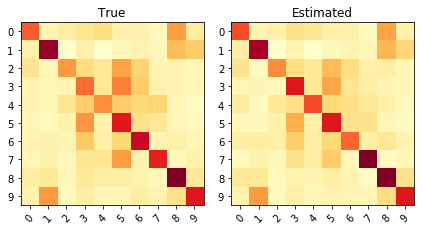

KL divergence: 0.0263	Pearson Correlation between diagonals: 0.6882


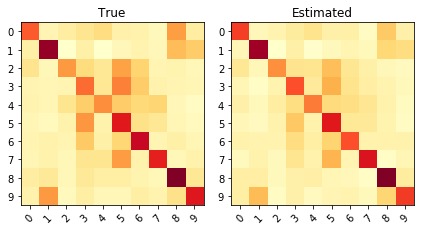

KL divergence: 0.0230	Pearson Correlation between diagonals: 0.8873


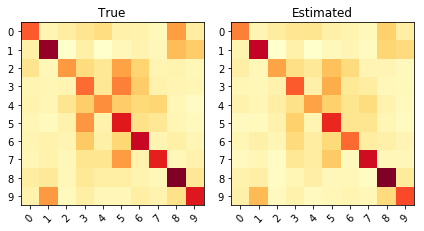

KL divergence: 0.0226	Pearson Correlation between diagonals: 0.8685


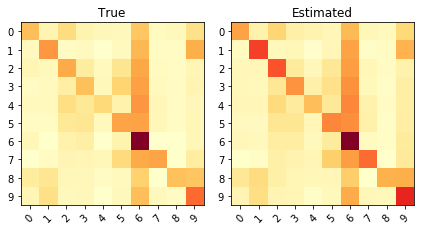

KL divergence: 0.0280	Pearson Correlation between diagonals: 0.9506


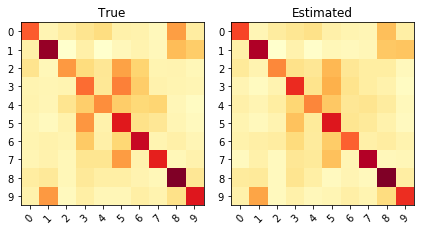

KL divergence: 0.0275	Pearson Correlation between diagonals: 0.7901


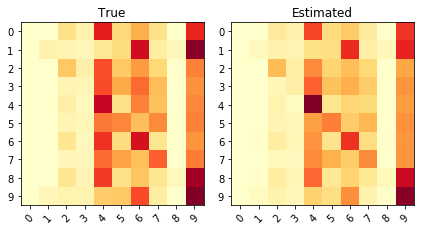

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9810


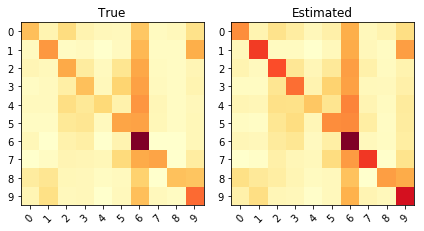

KL divergence: 0.0351	Pearson Correlation between diagonals: 0.9119


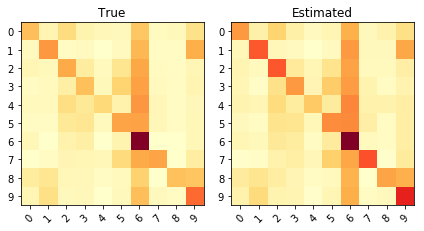

KL divergence: 0.0308	Pearson Correlation between diagonals: 0.9528


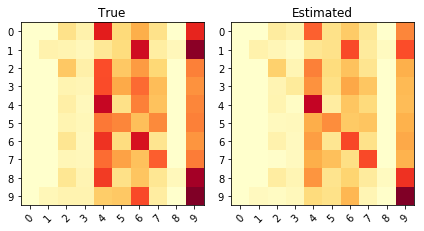

KL divergence: 0.0208	Pearson Correlation between diagonals: 0.9881


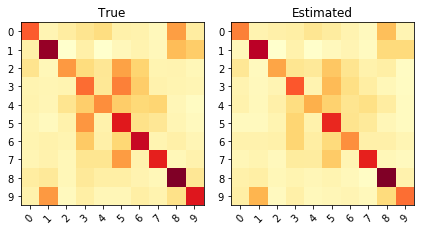

KL divergence: 0.0261	Pearson Correlation between diagonals: 0.8279


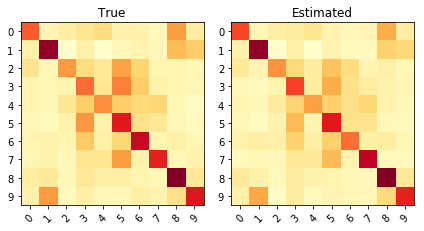

KL divergence: 0.0199	Pearson Correlation between diagonals: 0.8293


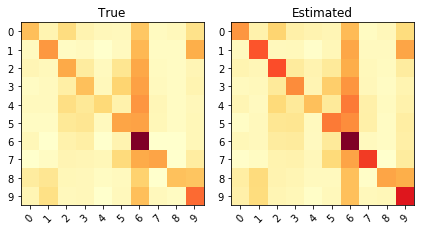

KL divergence: 0.0282	Pearson Correlation between diagonals: 0.9371
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |    0.65456 |      0.65456 |    0.0295881 |              0.885297 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.5965 |       0.5965 |
+----+--------+------------+--------------+


In [26]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


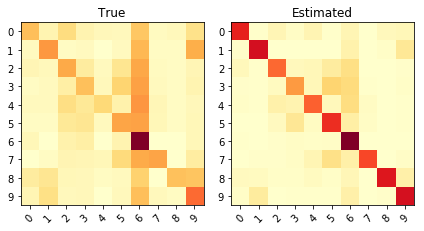

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.7813


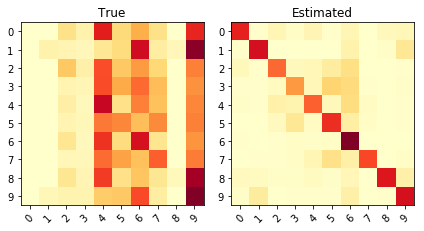

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.2749


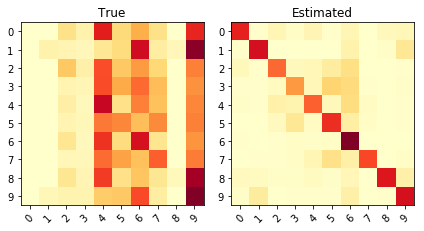

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.2749


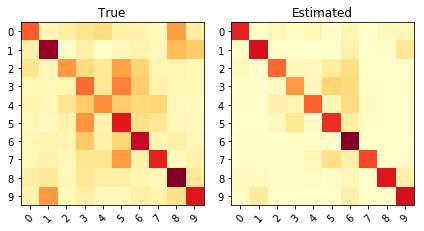

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


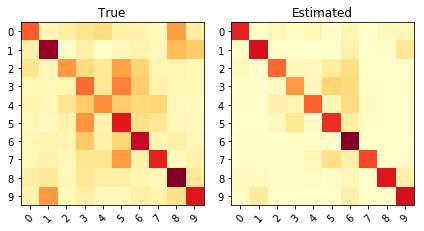

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


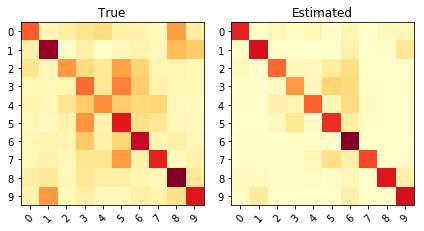

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


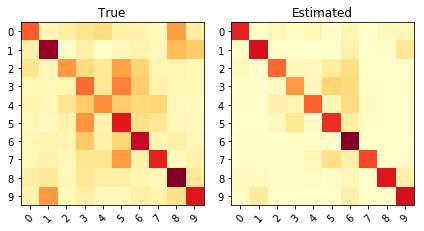

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


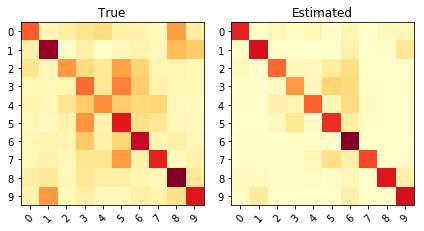

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


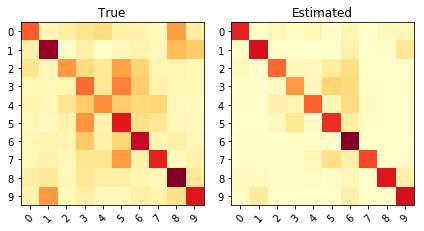

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


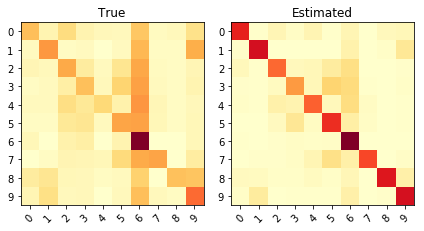

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.7813


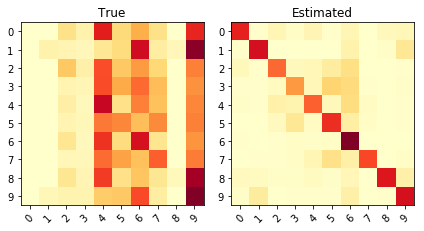

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.2749


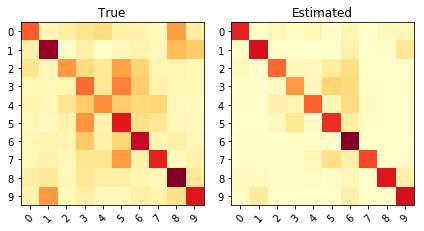

KL divergence: 0.4299	Pearson Correlation between diagonals: 0.6886


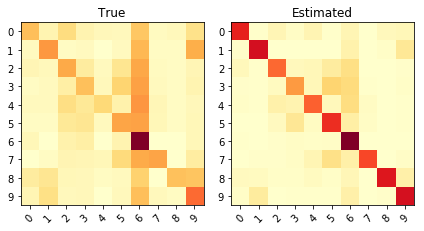

KL divergence: 0.5650	Pearson Correlation between diagonals: 0.7813


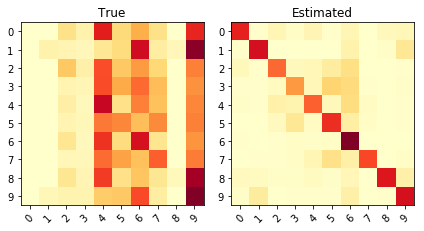

KL divergence: 0.5892	Pearson Correlation between diagonals: 0.2749


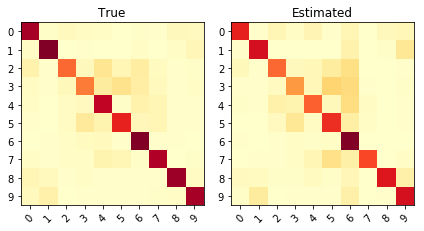

KL divergence: 1.3257	Pearson Correlation between diagonals: 0.8009
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |    0.65456 |      0.65456 |      0.58809 |              0.652569 |
+----+--------+------------+--------------+--------------+-----------------------+


In [27]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


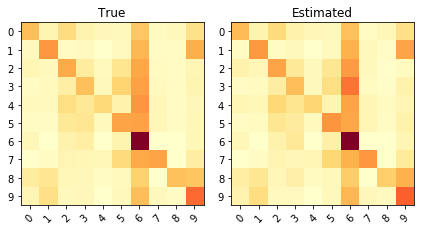

KL divergence: 0.0100	Pearson Correlation between diagonals: 0.9914


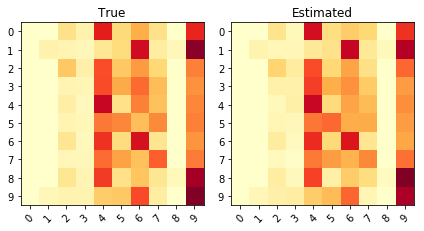

KL divergence: 0.0131	Pearson Correlation between diagonals: 0.9931


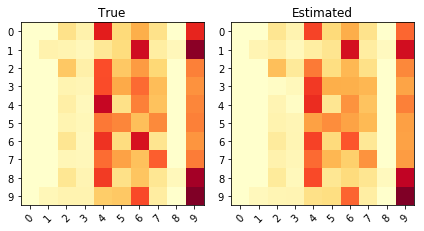

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9849


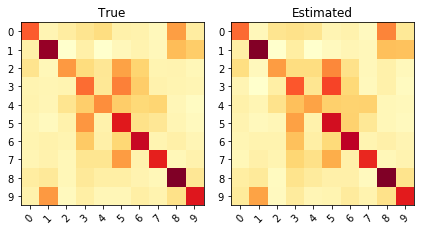

KL divergence: 0.0212	Pearson Correlation between diagonals: 0.9862


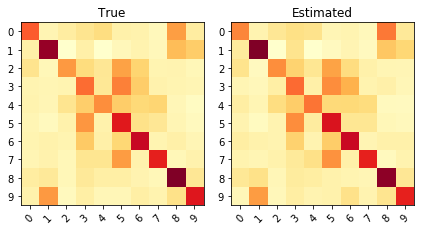

KL divergence: 0.0129	Pearson Correlation between diagonals: 0.9738


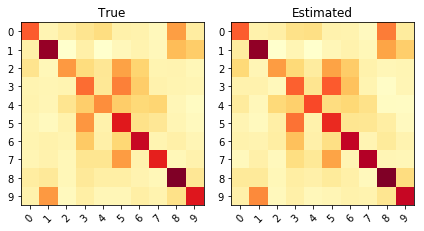

KL divergence: 0.0153	Pearson Correlation between diagonals: 0.9349


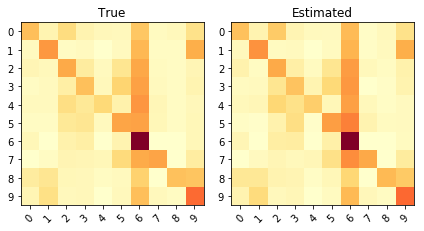

KL divergence: 0.0249	Pearson Correlation between diagonals: 0.9965


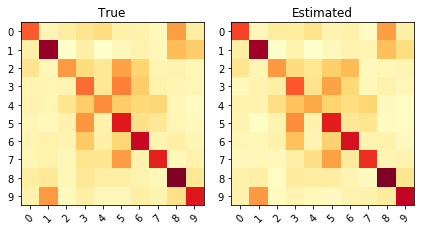

KL divergence: 0.0165	Pearson Correlation between diagonals: 0.9623


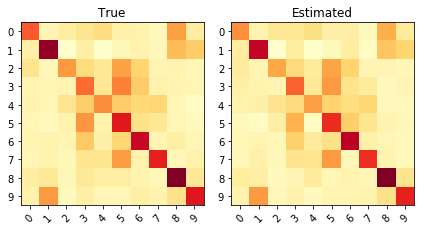

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9726


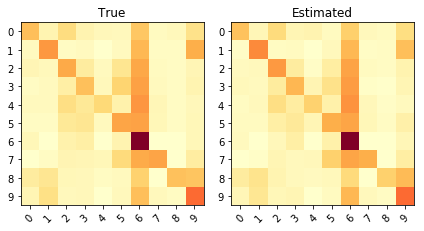

KL divergence: 0.0158	Pearson Correlation between diagonals: 0.9863


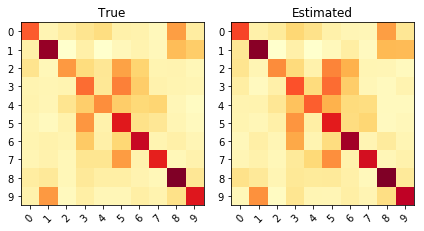

KL divergence: 0.0150	Pearson Correlation between diagonals: 0.9798


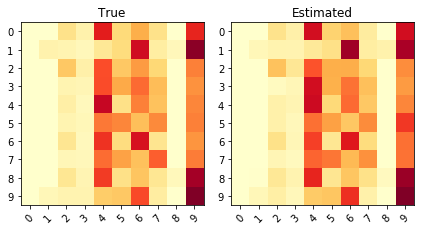

KL divergence: 0.0099	Pearson Correlation between diagonals: 0.9945


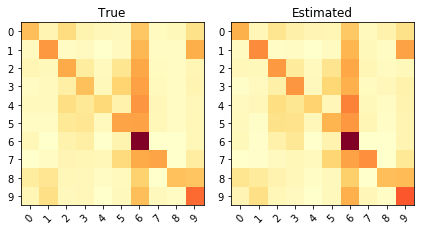

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9737


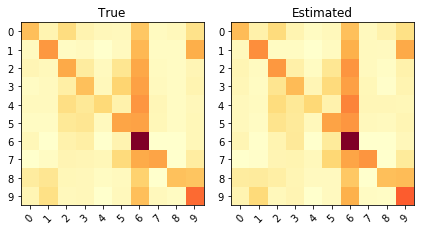

KL divergence: 0.0142	Pearson Correlation between diagonals: 0.9950


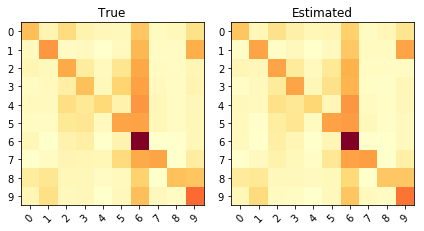

KL divergence: 0.0168	Pearson Correlation between diagonals: 0.9856
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |    0.81966 |      0.81966 |    0.0176059 |              0.978793 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |     0.7095 |       0.7095 |
+----+--------+------------+--------------+


In [29]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


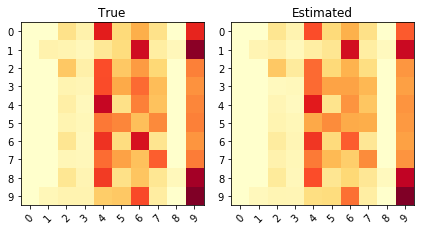

KL divergence: 0.0119	Pearson Correlation between diagonals: 0.9874


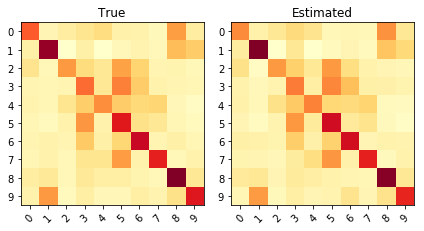

KL divergence: 0.0110	Pearson Correlation between diagonals: 0.9737


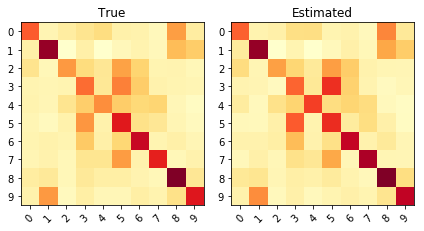

KL divergence: 0.0135	Pearson Correlation between diagonals: 0.9117


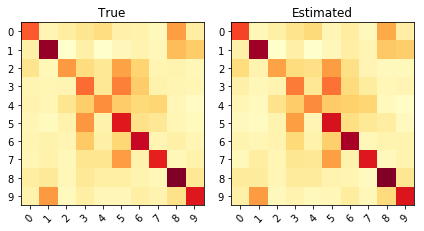

KL divergence: 0.0095	Pearson Correlation between diagonals: 0.9847


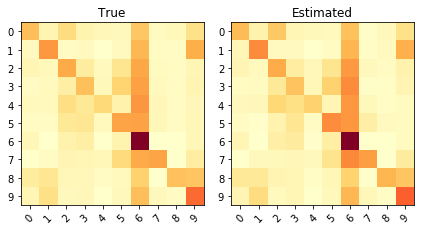

KL divergence: 0.0165	Pearson Correlation between diagonals: 0.9913


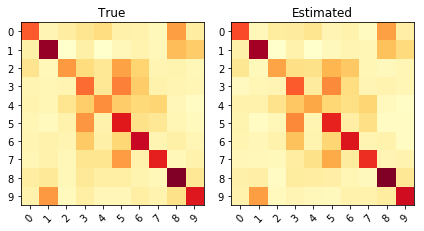

KL divergence: 0.0125	Pearson Correlation between diagonals: 0.9723


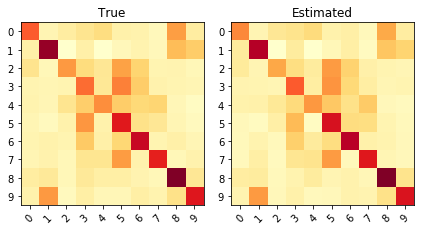

KL divergence: 0.0133	Pearson Correlation between diagonals: 0.9736


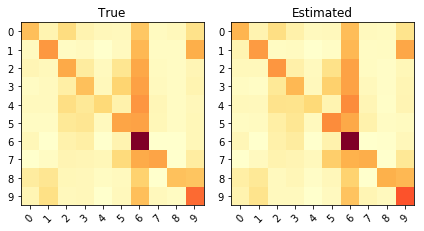

KL divergence: 0.0119	Pearson Correlation between diagonals: 0.9841


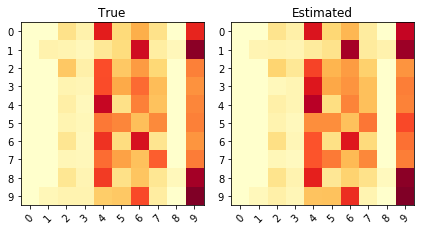

KL divergence: 0.0132	Pearson Correlation between diagonals: 0.9965


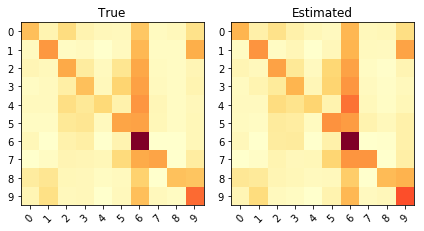

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9952


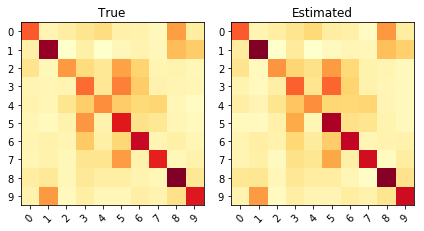

KL divergence: 0.0091	Pearson Correlation between diagonals: 0.9702


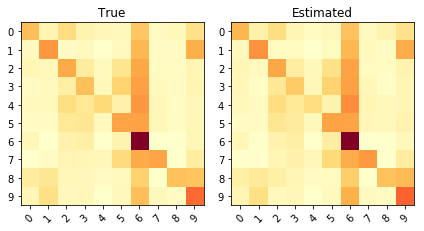

KL divergence: 0.0124	Pearson Correlation between diagonals: 0.9954


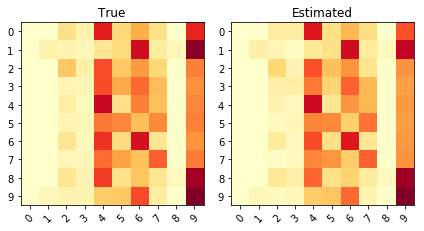

KL divergence: 0.0141	Pearson Correlation between diagonals: 0.9976


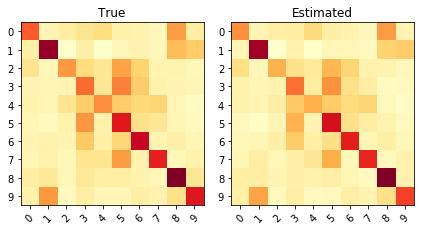

KL divergence: 0.0120	Pearson Correlation between diagonals: 0.9721


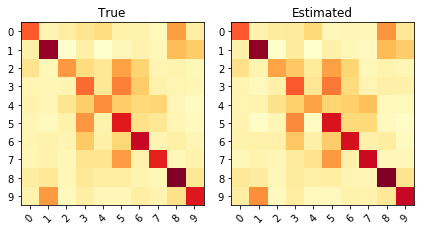

KL divergence: 0.0136	Pearson Correlation between diagonals: 0.9716
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.83268 |      0.83268 |    0.0131575 |              0.979679 |      0.0472543 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.367267 |                1.74902 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [30]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


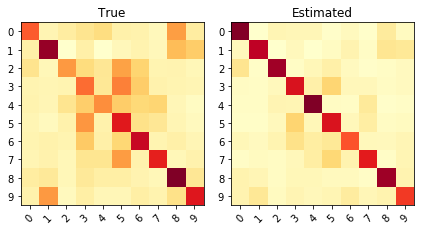

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


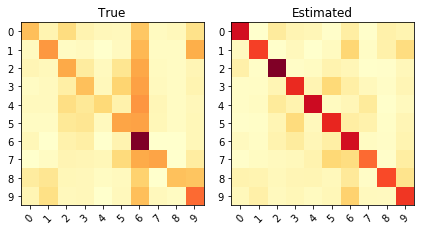

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479


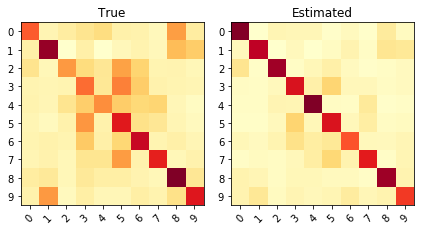

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


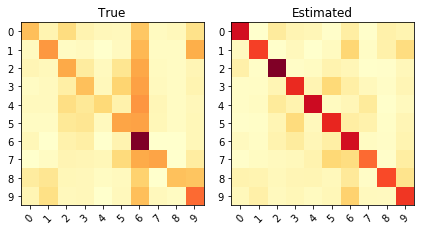

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479


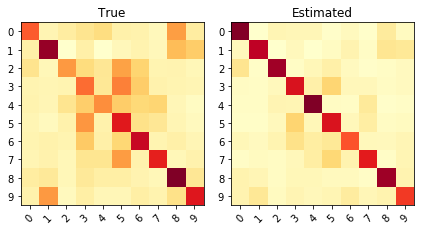

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


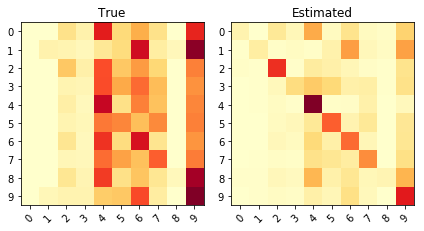

KL divergence: 0.2378	Pearson Correlation between diagonals: 0.8596


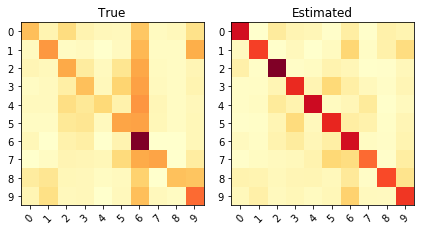

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479


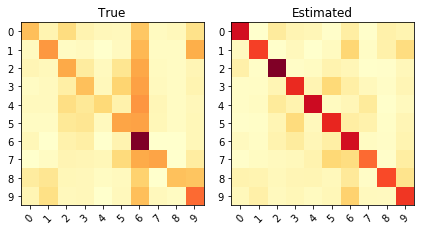

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479


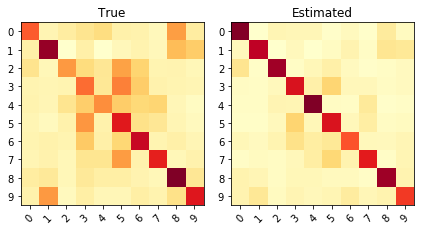

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


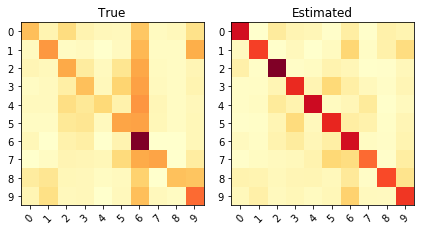

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479


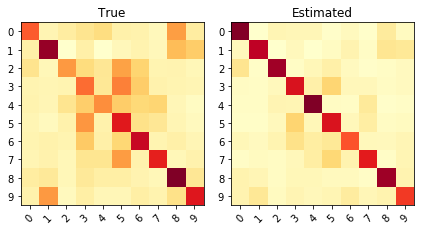

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


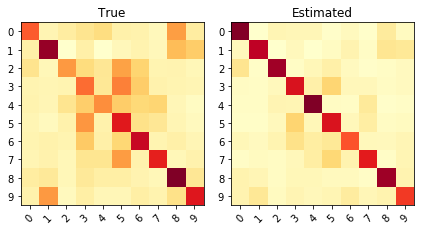

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


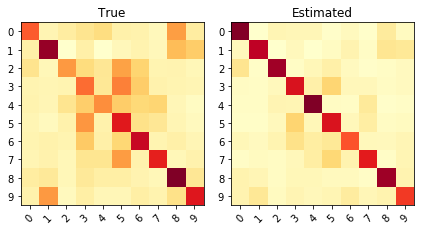

KL divergence: 0.2089	Pearson Correlation between diagonals: -0.3334


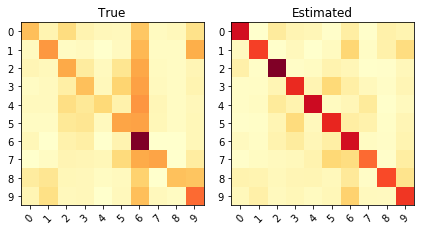

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479


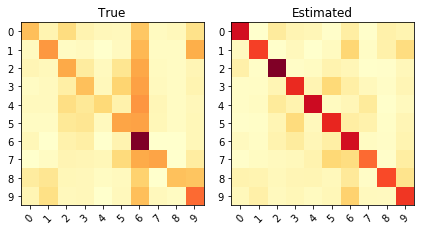

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.0479
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.67584       0.67584      0.232876              0.0441825       0.0498717
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.364138                 1.81104
====  =======================  ======================
Test


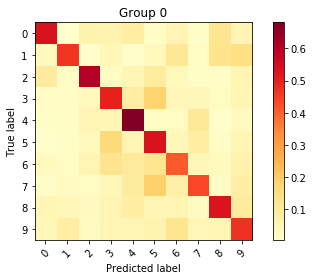

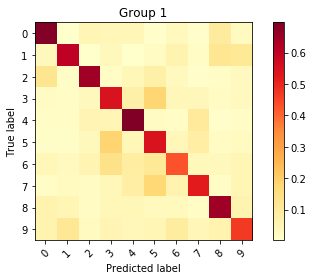

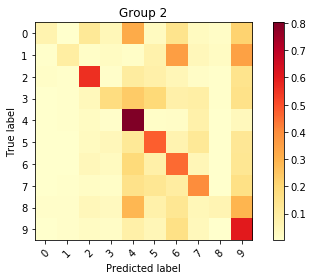

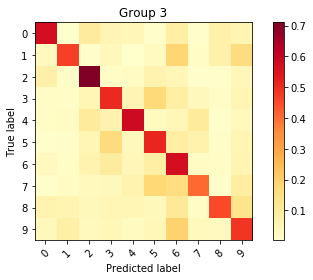

Inertia: 0.054940168862231076
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.143244      14    1.6284      0.517335   0.66949             0.699735      0.6945        0.6945
   1         1  0.341328      34    1.47727     0.579592   0.5574              0.745844      0.7027        0.7027
   2         2  0.161228      16    1.57205     0.370856   1.3241              0.527812      0.4328        0.4328
   3         3  0.3542        35    1.57758     0.526733   0.652664            0.706665      0.6158        0.6158
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============

In [18]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


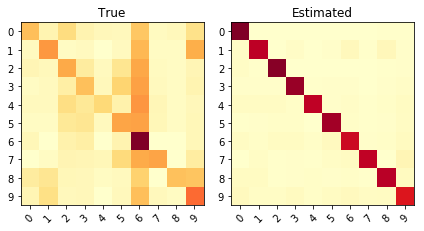

KL divergence: 1.2774	Pearson Correlation between diagonals: -0.5043


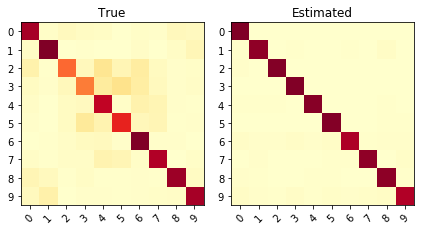

KL divergence: 0.5049	Pearson Correlation between diagonals: -0.5350


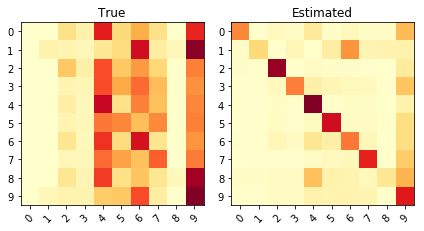

KL divergence: 0.6709	Pearson Correlation between diagonals: 0.6197


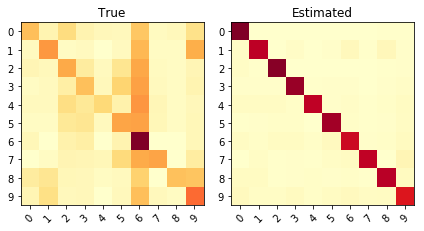

KL divergence: 1.2774	Pearson Correlation between diagonals: -0.5043


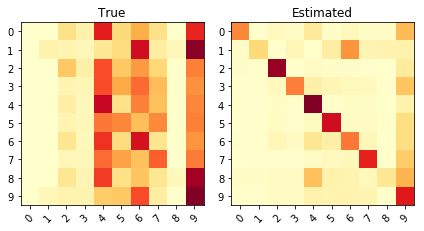

KL divergence: 0.6709	Pearson Correlation between diagonals: 0.6197


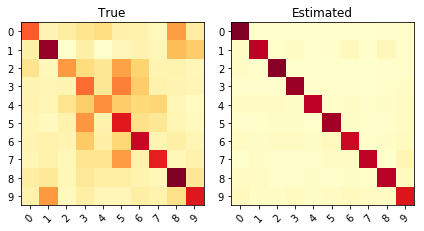

KL divergence: 1.0581	Pearson Correlation between diagonals: -0.5044


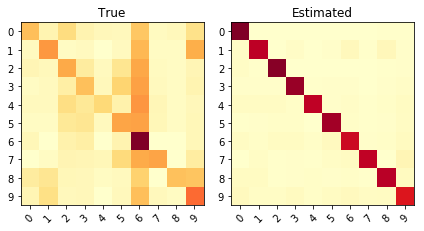

KL divergence: 1.2774	Pearson Correlation between diagonals: -0.5043


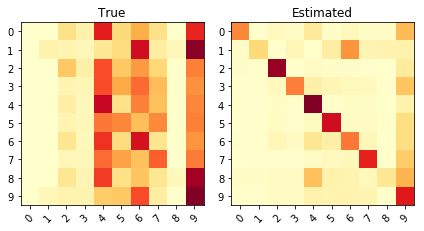

KL divergence: 0.6709	Pearson Correlation between diagonals: 0.6197


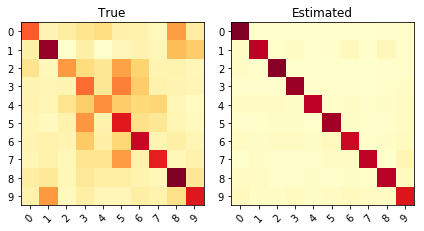

KL divergence: 1.0581	Pearson Correlation between diagonals: -0.5044


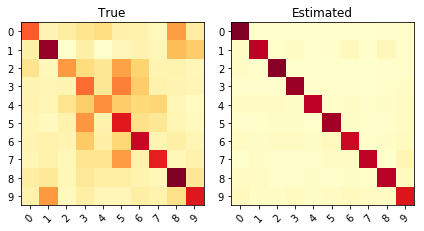

KL divergence: 1.0581	Pearson Correlation between diagonals: -0.5044


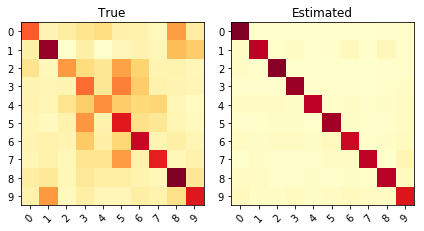

KL divergence: 1.0581	Pearson Correlation between diagonals: -0.5044


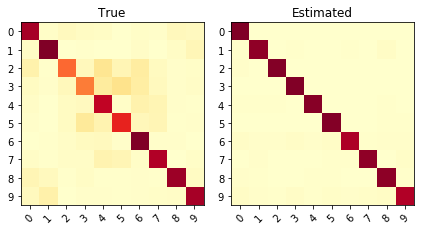

KL divergence: 0.5049	Pearson Correlation between diagonals: -0.5350


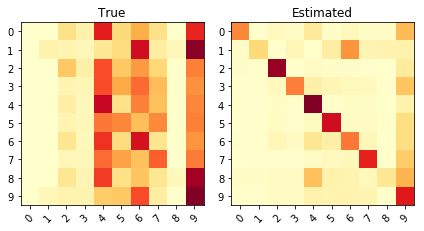

KL divergence: 0.6709	Pearson Correlation between diagonals: 0.6197


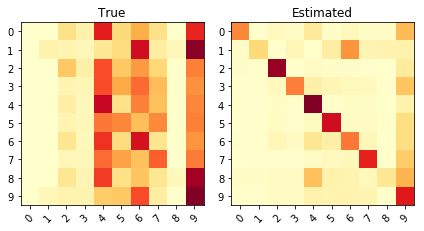

KL divergence: 0.6709	Pearson Correlation between diagonals: 0.6197


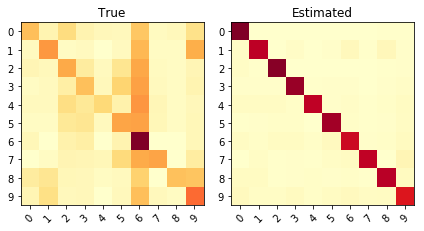

KL divergence: 1.2774	Pearson Correlation between diagonals: -0.5043
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.65824       0.65824      0.982878              -0.271397       0.0579462
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.362014                 1.82617
====  =======================  ======================
Test


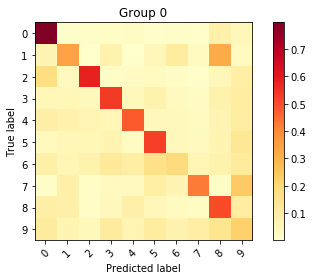

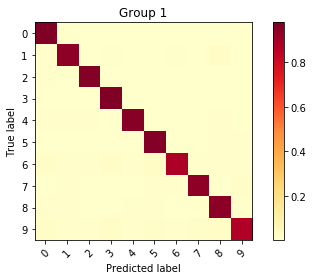

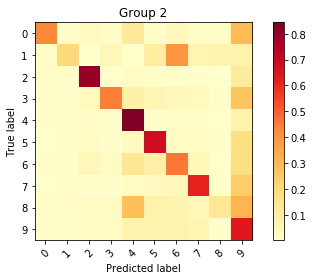

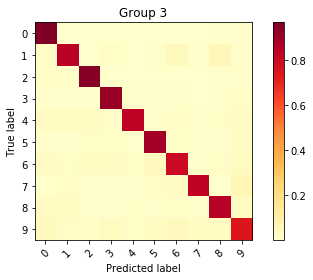

Inertia: 0.1118041241231064
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.169759      16   1.69165      0.46015   0.856443             0.63979       0.5441        0.5441
   1         1  0.317309      31   0.312683     0.945929  0.0562497            0.972196      0.6105        0.6105
   2         2  0.163092      16   1.33992      0.5265    0.770116             0.68276       0.4376        0.4376
   3         3  0.349841      34   0.651542     0.86405   0.148959             0.927505      0.6184        0.6184
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
 

In [19]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


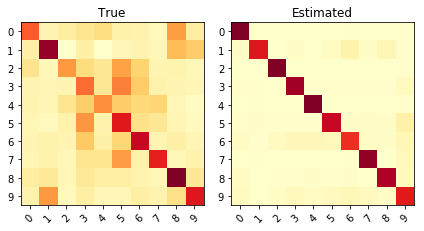

KL divergence: 1.5600	Pearson Correlation between diagonals: -0.6797


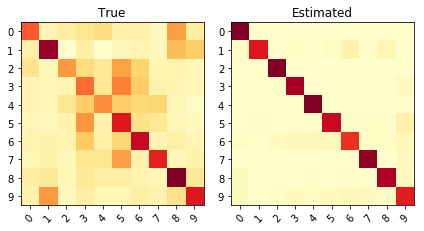

KL divergence: 1.5371	Pearson Correlation between diagonals: -0.6706


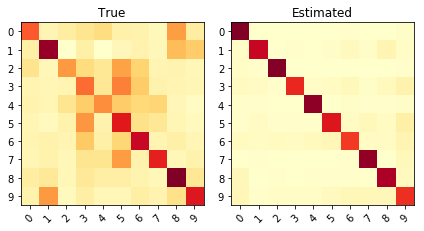

KL divergence: 1.2218	Pearson Correlation between diagonals: -0.3435


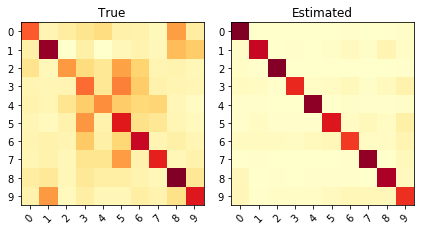

KL divergence: 1.2210	Pearson Correlation between diagonals: -0.3419


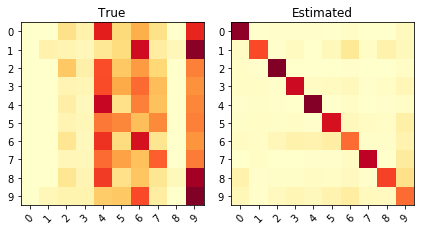

KL divergence: 1.3646	Pearson Correlation between diagonals: -0.2197


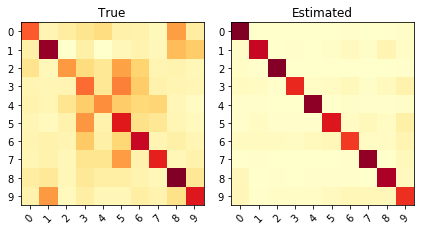

KL divergence: 1.2210	Pearson Correlation between diagonals: -0.3419


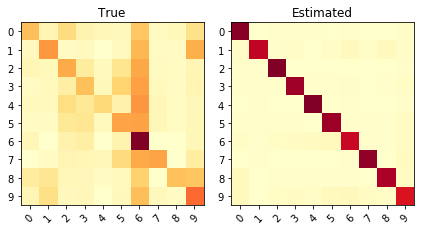

KL divergence: 1.4401	Pearson Correlation between diagonals: -0.6563


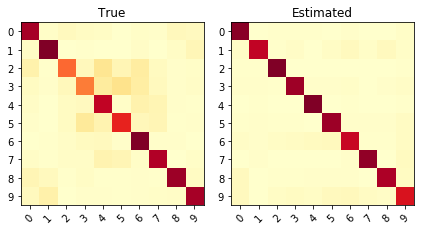

KL divergence: 0.3813	Pearson Correlation between diagonals: -0.4974


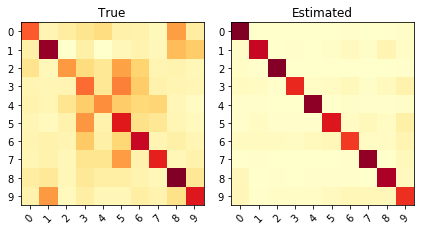

KL divergence: 1.2210	Pearson Correlation between diagonals: -0.3419


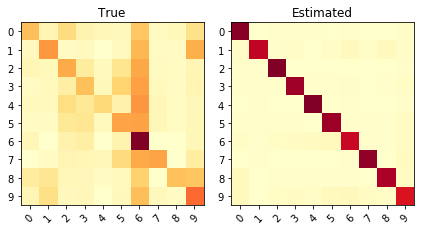

KL divergence: 1.4401	Pearson Correlation between diagonals: -0.6563


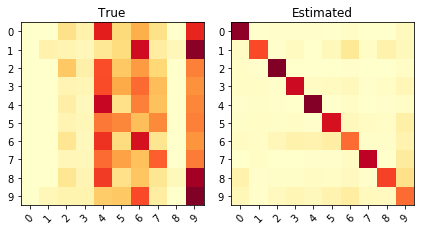

KL divergence: 1.3646	Pearson Correlation between diagonals: -0.2197


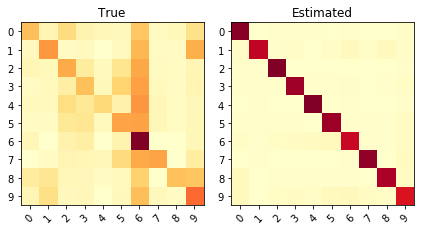

KL divergence: 1.4401	Pearson Correlation between diagonals: -0.6563


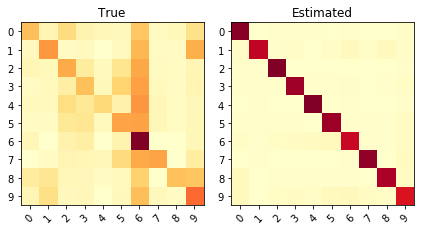

KL divergence: 1.4401	Pearson Correlation between diagonals: -0.6563


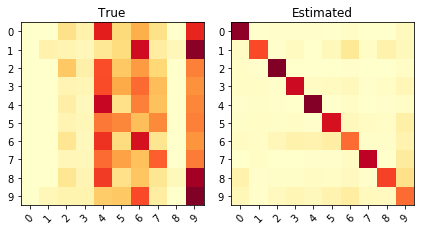

KL divergence: 1.3646	Pearson Correlation between diagonals: -0.2197


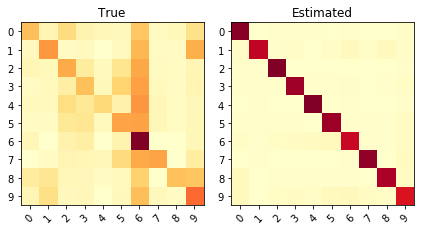

KL divergence: 1.4401	Pearson Correlation between diagonals: -0.6563
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.68088       0.68088       1.24231              -0.457485       0.0319536
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.368756                 1.82343
====  =======================  ======================
Test


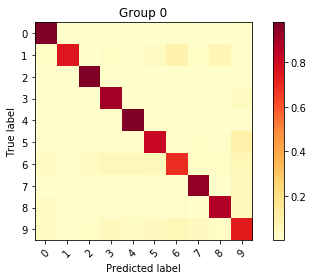

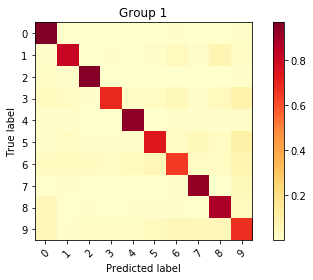

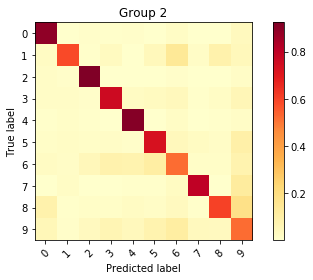

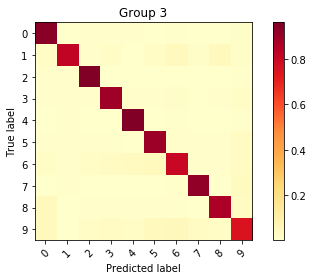

Inertia: 0.014706747761617104
A result
 ====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.525096       52   0.59912      0.86434    0.153484            0.926074      0.6552        0.6552
   1         1  0.264023       26   0.75386      0.823226   0.205191            0.901993      0.6527        0.6527
   2         2  0.0979888       9   1.04098      0.725203   0.343618            0.840105      0.657         0.657
   3         3  0.112892       11   0.575934     0.883104   0.127251            0.937954      0.6191        0.6191
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  =====

In [16]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [17]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7265145302906059


#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [ ]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))